# 0: Setting up the file + dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/Shared drives/DSF_Project'

/content/drive/Shared drives/DSF_Project


In [3]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
# setting all global variables here
data_root = 'raw data/'

# 1: Data Cleaning

In [5]:
# for row in oldnewcountries[].iterrows():
#   old_country = row[1].old_country
#   new_country = row[1].new_country
#   if old_country not in oldnewcountries_dict:
#     oldnewcountries_dict[old_country] = new_country

In [6]:
df_changeCountryName = pd.read_csv("raw data/OldNewCountries.csv")

newNames_WB = {}
newNames_UN = {}
newNames_WHR = {}
for index, row in df_changeCountryName.iterrows():
    
    if row['data_source'] == 'WB':
        newNames_WB[row['old_country']] = row['new_country']
    elif row['data_source'] == 'UN':
        newNames_UN[row['old_country']] = row['new_country']
    elif row['data_source'] == 'WHR':
        newNames_WHR[row['old_country']] = row['new_country']

In [7]:
backward_looking_years = 5

def getAllCountries():
    
    filename = data_root + 'all_countries.csv'
    df = pd.read_csv(filename)

    return df

def fixCountryNames(x, oldnewcountries_dict):
    if x in oldnewcountries_dict:
      return oldnewcountries_dict[x] 
    else:
      return x

def clean_missing_UNHDR(df):
    for col in df.columns[2:]:
      df[col] = df[col].replace({' ':'0'})
      df[col] = df[col].replace({'..':'0'})
      df[col] = df[col].apply(literal_eval)

def impute_empty_values_AK(df, backtrace_num, curr_year, years):
    backtrace_resetter = backtrace_num
    columns = years[::-1]
    for index, row in df.iterrows():
        if df[curr_year].iloc[index] == 0:
            counter = 0
            while backtrace_num > 0:
                value = df[columns[counter]].iloc[index]
                if value != 0:
                  df.loc[df.Country == df.iloc[index].Country, curr_year] = value
                  break
                backtrace_num -= 1
                counter += 1
            backtrace_num = backtrace_resetter 

def impute_empty_values(df, backtrace_num, curr_year):
    for i in range(1,backtrace_num+1):
        new_col = str(int(curr_year)-i)
        if new_col in df.columns:
            df[curr_year] = df.apply(lambda x: max(x[curr_year],x[new_col] if x[curr_year]==0 else x[curr_year]), axis=1)

    return df

def preProcessing_UNHDR(df, curr_year):
    df['Country'] = df['Country'].apply(lambda x: fixCountryNames(x, oldnewcountries_dict=newNames_UN))
    clean_missing_UNHDR(df)
    df = impute_empty_values(df, backward_looking_years, curr_year)
    median_2018 = df[df[curr_year]!=0][curr_year].median() 
    df[curr_year] = df[curr_year].replace({0:median_2018})

    return df


def preProcessing_WorldBank(df, curr_year):
    df['Country Name'] = df['Country Name'].apply(lambda x: fixCountryNames(x, oldnewcountries_dict=newNames_WB))
    df.fillna(0, inplace=True)
    df = impute_empty_values(df, backward_looking_years, curr_year)
    median_2018 = df[df[curr_year]!=0][curr_year].median() 
    df[curr_year] = df[curr_year].replace({0:median_2018})
    
    return df



In [8]:
preProcessData = True

if preProcessData:
    # create the main df
    df_main = getAllCountries()

    # open the control file
    control_filename = 'data_cleaning_control.csv'
    df_control = pd.read_csv(control_filename)

    # loop for each file
    for index, row in df_control.iterrows():
        # make the file name and read it
        filename = row['folder_path'] + '/' + row['filename']
        if filename[:-4] != '.csv':
            filename += '.csv'
        df_temp = pd.read_csv(filename)

        # get the needed variables
        merge_col = row['merge_col']
        data_col = str(row['data_year'])
        new_col_name =  row['new_col_name']
        data_source = row['data_source']

        # preprocess the file as per the data source
        if data_source == 'World Bank':
            df_temp = preProcessing_WorldBank(df_temp, data_col)
        elif data_source == 'UN Human Development Data ':
            df_temp = preProcessing_UNHDR(df_temp, data_col)
        else:
            print('Data Source not Found! File: ', filename, data_source)

        # get the columns to select and extract only those
        sel_cols = [merge_col,data_col]
        df_temp = df_temp[sel_cols]

        # update the year column to variable name
        df_temp = df_temp.rename(columns={data_col: new_col_name})

        # merge with the main dataset and remove the merge col
        df_main = df_main.merge(df_temp, how='left', left_on='country', right_on=merge_col)
        df_main = df_main.drop(columns=merge_col)

        # clean up all the null values if any
        if df_main[new_col_name].isnull().sum() > 0: 
            df_main[new_col_name].fillna(df_main[new_col_name].median(), inplace=True)

    # save the main data
    df_main.to_csv('main.csv')
else:
    df_main = pd.read_csv('main.csv')

In [9]:
df_main 

,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Afghanistan,AF,Asia,Eastern Mediterranean,South Asia,East Asia,638.0,65.141000,0.63602,27.710843,43.019718,0.3,64.5,37.4,2.10,10.6
1,Albania,AL,Balkan,Europe,Europe and Central Asia,Eastern Europe,15.0,19.572400,1.01730,27.857143,98.141151,1.1,78.5,29.0,4.30,7.0
2,Algeria,DZ,Africa,Africa,Middle East and North Africa,Africa,112.0,9.833800,0.99702,25.757576,81.407837,9.3,76.7,27.6,1.80,4.9
3,Andorra,AD,Europe,Europe,Europe and Central Asia,Western Europe,67.0,39.089300,0.99702,32.142857,91.293808,1.9,81.8,37.4,4.45,13.6
4,Angola,AO,Africa,Africa,Sub-Saharan Africa,Africa,241.0,147.958000,0.99702,30.454545,66.030113,12.8,60.8,42.7,4.60,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Vietnam,VN,Asia,Western Pacific,East Asia and Pacific,East Asia,43.0,29.151800,0.99702,26.720648,95.000381,1.0,75.3,35.3,3.40,10.8
188,World,NaN,NaN,NaN,NaN,NaN,211.0,42.035603,0.98576,24.097878,86.246941,1.1,72.6,37.4,7.40,13.7
189,Yemen,YE,Middle East,Eastern Mediterranean,Middle East and North Africa,Western Asia,164.0,59.162400,0.82074,0.332226,91.293808,0.2,66.1,36.7,6.20,13.4
190,Zambia,ZM,Africa,Africa,Sub-Saharan Africa,Africa,213.0,118.304800,0.99702,17.964072,86.747963,8.3,63.5,57.1,6.20,17.5


# 2: Baseline Analysis (Preprocessing)

Read the WHR20 data and ladder Rank

In [11]:
def get_all_features():
  df_WHR20 = pd.read_csv(data_root + 'WHR2020/WHR20_DataForFigure2.1.csv')

  # Rank by Ladder Score
  # using Max Rank
  df_WHR20['Ladder Rank'] = df_WHR20['Ladder score'].rank(method='max', ascending = False)
  # clean the counrty names
  df_WHR20['Country name'] = df_WHR20['Country name'].apply(lambda x: fixCountryNames(x, oldnewcountries_dict=newNames_WHR))

  # merge the data
  df_allFeatures = df_WHR20.merge(df_main, how='left', left_on='Country name', right_on='country')
  df_allFeatures = df_allFeatures[df_allFeatures.notnull().all(axis=1)]
  return df_allFeatures

In [12]:
def compareAnalysis(df_baseline, topn=6, show_top_tables=False):

    if show_top_tables:

        print('Countries with most change in rank')
        display(df_baseline.sort_values(rank_change_abs,ascending=False).head(topn)[display_cols])

        print('Countries with least/no change in rank')
        display(df_baseline.sort_values(rank_change_abs).head(topn)[display_cols])

        print('WHR20 Top 10')
        display(df_baseline.sort_values(main_score_rank).head(topn)[display_cols])

        print('Baseline Top 10')
        display(df_baseline.sort_values(scoring_rank).head(topn)[display_cols])

    fig, axs = plt.subplots(1, 3, figsize=(22,5))

    rank_range = [1,df_baseline.shape[0]]
    axs[0].scatter(df_baseline[main_score_rank],df_baseline[scoring_rank])
    axs[0].plot(rank_range, rank_range, 'k-', lw=2)
    axs[0].set_xlabel(main_score_rank)
    axs[0].set_ylabel(scoring_rank)
    axs[0].set_title('---- Change in the Ranks ----')

    axs[1].hist(df_baseline[rank_change_abs])
    axs[1].set_title('---- Absolute Change in Rank - Histogram ----')

    axs[2].hist(df_baseline[rank_change])
    axs[2].set_title('---- Change in Rank - Histogram ----')

In [13]:
def getCorrelationPlot(df):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.heatmap(df.corr(),ax=ax, vmin=-1, vmax=1, cmap='seismic', linewidths=0.2, annot = True, annot_kws={'fontsize':12})

# making a function to plot bar charts when needed quickly
# this should also take care of x and y axis with labels on x axis
def plotBarChart(df, title = "", xlab = "",ylab = "",xlabs_custom=[],rotation=45):
    sns.set(font_scale=1.4)
    df.plot.bar(figsize=(26, 6), linewidth=2)
    plt.xlabel(xlab, labelpad=8)

    plt.ylabel(ylab, labelpad=8)
    plt.title(title, y=1.02, fontsize=22)

    xi = range(len(xlabs_custom))
    if len(xi)>0:
        plt.xticks(xi, xlabs_custom)
        plt.xticks(rotation=rotation)

def plotLineChart(df, title = "", xlab = "",ylab = "",xlabs_custom=[]):
    sns.set(font_scale=1.4)
    df.plot(figsize=(26, 8), linewidth=2)
    plt.xlabel(xlab, labelpad=8)
    plt.ylabel(ylab, labelpad=8)
    plt.title(title, y=1.02, fontsize=22)

    xi = range(len(xlabs_custom))
    if len(xi)>0:
        plt.xticks(xi, xlabs_custom)
        plt.xticks(rotation=90)

In [14]:
final_scores_all_countries = pd.DataFrame()
final_scores_all_countries['Country name'] = get_all_features()['Country name']
final_scores_all_countries = pd.merge(final_scores_all_countries, get_all_features()[['Country name', 'Ladder score']], how='left', on='Country name')
final_scores_all_countries

,Country name,Ladder score
0,Finland,7.8087
1,Denmark,7.6456
2,Switzerland,7.5599
3,Iceland,7.5045
4,Norway,7.4880
...,...,...
140,Central African Republic,3.4759
141,Rwanda,3.3123
142,Zimbabwe,3.2992
143,South Sudan,2.8166


# 3: Scoring Function 1: Baseline Rank
# (Ladder Score + Baseline Variables)

- Adding all the variables to the ladder score.
- Each variable is normalized and added to ladder score.
- Ranked by Max method

In [15]:
from sklearn import preprocessing

# rank variable names
scoring_name = 'Baseline Score'
scoring_rank = 'Baseline Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'

df_allFeatures = get_all_features()
df_baseline = df_allFeatures

# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'svg-id', 'Ladder score', 'Baseline Score', 'Ladder Rank', 'Baseline Rank', 'Baseline Rank Change']

# normalie basline variables
df_baseline[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_baseline[baseline_cols+baseline_cols_neg])

# get the baseline score
df_baseline['Baseline Score'] = df_baseline.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_baseline['Baseline Rank'] = df_baseline['Baseline Score'].rank(method='max',ascending = False)
df_baseline['Ladder Rank'] = df_baseline['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_baseline['Baseline Rank Change'] = df_baseline['Baseline Rank'] - df_baseline['Ladder Rank']
df_baseline['Baseline Rank Change (Abs)'] = abs(df_baseline['Baseline Rank Change'])

# save the data file
df_baseline.to_csv('baseline.csv')

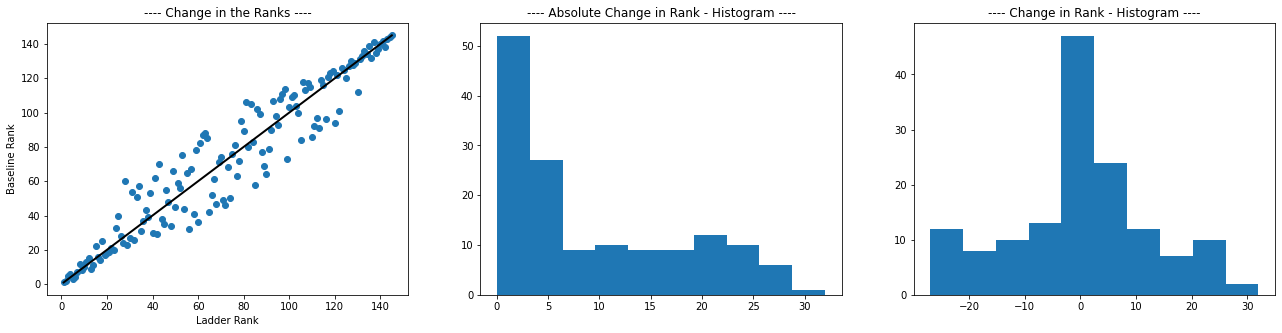

In [16]:
compareAnalysis(df_baseline)

In [17]:
df_baseline

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Baseline Score,Baseline Rank,Baseline Rank Change,Baseline Rank Change (Abs)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,0.028154,0.053107,0.009928,0.394162,0.856775,0.000938,81.7,0.254328,0.063817,0.195204,8.474017,1.0,0.0,0.0
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,0.038550,0.040178,0.009636,0.360730,0.879835,0.003855,80.8,0.271775,0.050114,0.127214,8.364114,2.0,0.0,0.0
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,0.048184,0.025478,0.009352,0.313197,0.879784,0.018310,83.6,0.311270,0.066494,0.152262,8.140235,5.0,2.0,2.0
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,0.037954,0.056045,0.009437,0.361468,0.866245,0.018028,82.9,0.263781,0.044596,0.205901,8.115344,6.0,2.0,2.0
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,0.018997,0.048488,0.009285,0.393426,0.867147,0.041793,82.3,0.261207,0.061740,0.129179,8.196455,3.0,-2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,141.0,Central African Republic,CF,Africa,Africa,Sub-Saharan Africa,Africa,0.984986,0.150853,0.000904,0.010184,0.044432,0.000119,52.8,0.066775,0.007129,0.021387,2.300172,142.0,1.0,1.0
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,142.0,Rwanda,RW,Africa,Africa,Sub-Saharan Africa,Africa,0.909291,0.142451,0.003709,0.224573,0.268445,0.019799,68.7,0.160226,0.021999,0.061964,2.493297,138.0,-4.0,4.0
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,143.0,Zimbabwe,ZW,Africa,Africa,Sub-Saharan Africa,Africa,0.958338,0.174193,0.002030,0.065873,0.185586,0.006487,61.2,0.090393,0.023226,0.060890,2.239162,143.0,0.0,0.0
151,South Sudan,Sub-Saharan Africa,2.8166,0.1076

In [18]:
final_scores_all_countries = pd.merge(final_scores_all_countries, df_baseline[['Country name','Baseline Score', 'Baseline Rank', 'Baseline Rank Change', 'Baseline Rank Change (Abs)']], 
         how='left', on='Country name')

In [19]:
replace_cols = {'Baseline Score': 'baseline_score',
                'Baseline Rank': 'baseline_rank',
                'Baseline Rank Change': 'baseline_rc',
                'Baseline Rank Change (Abs)': 'baseline_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0
...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0


# 4: Scoring Function 2: Baseline Correlated Rank
# (Ladder Score + Baseline Correlated Variables)


In [20]:
df_main

,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Afghanistan,AF,Asia,Eastern Mediterranean,South Asia,East Asia,638.0,65.141000,0.63602,27.710843,43.019718,0.3,64.5,37.4,2.10,10.6
1,Albania,AL,Balkan,Europe,Europe and Central Asia,Eastern Europe,15.0,19.572400,1.01730,27.857143,98.141151,1.1,78.5,29.0,4.30,7.0
2,Algeria,DZ,Africa,Africa,Middle East and North Africa,Africa,112.0,9.833800,0.99702,25.757576,81.407837,9.3,76.7,27.6,1.80,4.9
3,Andorra,AD,Europe,Europe,Europe and Central Asia,Western Europe,67.0,39.089300,0.99702,32.142857,91.293808,1.9,81.8,37.4,4.45,13.6
4,Angola,AO,Africa,Africa,Sub-Saharan Africa,Africa,241.0,147.958000,0.99702,30.454545,66.030113,12.8,60.8,42.7,4.60,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Vietnam,VN,Asia,Western Pacific,East Asia and Pacific,East Asia,43.0,29.151800,0.99702,26.720648,95.000381,1.0,75.3,35.3,3.40,10.8
188,World,NaN,NaN,NaN,NaN,NaN,211.0,42.035603,0.98576,24.097878,86.246941,1.1,72.6,37.4,7.40,13.7
189,Yemen,YE,Middle East,Eastern Mediterranean,Middle East and North Africa,Western Asia,164.0,59.162400,0.82074,0.332226,91.293808,0.2,66.1,36.7,6.20,13.4
190,Zambia,ZM,Africa,Africa,Sub-Saharan Africa,Africa,213.0,118.304800,0.99702,17.964072,86.747963,8.3,63.5,57.1,6.20,17.5


In [21]:
df_allFeatures = get_all_features()
df_allFeatures

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,3.0,5.6588,1.05790,42.000000,91.293808,0.1,81.7,27.1,6.8,20.8
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,4.0,4.1690,0.99982,37.430168,91.293808,0.4,80.8,28.2,5.2,13.2
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,5.0,2.6438,0.97046,32.500000,91.293808,1.9,83.6,32.3,6.9,15.8
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,4.0,5.9066,0.99461,38.095238,91.293808,1.9,82.9,27.8,4.7,21.7
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,2.0,5.1048,0.97754,41.420118,91.293808,4.4,82.3,27.5,6.5,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,149.0,Central African Republic,CF,Africa,Africa,Sub-Saharan Africa,Africa,829.0,126.9636,0.76095,8.571429,37.395821,0.1,52.8,56.2,6.0,18.0
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,150.0,Rwanda,RW,Africa,Africa,Sub-Saharan Africa,Africa,248.0,38.8520,1.01159,61.250000,73.215591,5.4,68.7,43.7,6.0,16.9
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,151.0,Zimbabwe,ZW,Africa,Africa,Sub-Saharan Africa,Africa,458.0,83.2486,0.97012,31.481481,88.693420,3.1,61.2,43.2,11.1,29.1
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,152.0,South Sudan,SS,Africa,Africa,Sub-Saharan Africa,Africa,1150.0,59.4332,0.68539,28.459530,34.522758,14.0,57.6,46.3,4.1,8.3


In [22]:
baseline_cols = ['Country name','Ladder score','school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate', 'life_expectancy']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
baseline_correlated = df_allFeatures[baseline_cols + baseline_cols_neg]

In [23]:
baseline_correlated

,Country name,Ladder score,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,life_expectancy,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,natural_resource_depletion,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Finland,7.8087,1.05790,42.000000,91.293808,81.7,3.0,5.6588,0.1,27.1,6.8,20.8
1,Denmark,7.6456,0.99982,37.430168,91.293808,80.8,4.0,4.1690,0.4,28.2,5.2,13.2
2,Switzerland,7.5599,0.97046,32.500000,91.293808,83.6,5.0,2.6438,1.9,32.3,6.9,15.8
3,Iceland,7.5045,0.99461,38.095238,91.293808,82.9,4.0,5.9066,1.9,27.8,4.7,21.7
4,Norway,7.4880,0.97754,41.420118,91.293808,82.3,2.0,5.1048,4.4,27.5,6.5,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,3.4759,0.76095,8.571429,37.395821,52.8,829.0,126.9636,0.1,56.2,6.0,18.0
149,Rwanda,3.3123,1.01159,61.250000,73.215591,68.7,248.0,38.8520,5.4,43.7,6.0,16.9
150,Zimbabwe,3.2992,0.97012,31.481481,88.693420,61.2,458.0,83.2486,3.1,43.2,11.1,29.1
151,South Sudan,2.8166,0.68539,28.459530,34.522758,57.6,1150.0,59.4332,14.0,46.3,4.1,8.3


In [24]:
correlation_values = baseline_correlated.corr().iloc[0]
correlation_values

Ladder score                        1.000000
school_secondary_enrollment_gpi     0.336205
women_seats_parliament              0.327640
literacy_rate                       0.534331
life_expectancy                     0.760263
maternal_mortality_ratio_per100k   -0.631733
adolescent_fetility_per1k          -0.540611
natural_resource_depletion         -0.310049
income_inequality                  -0.353398
female_suicide_per100k             -0.246942
male_suicide_per100k                0.014560
Name: Ladder score, dtype: float64

In [25]:
from sklearn import preprocessing


df_baseline_correlated = df_allFeatures

# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate', 'life_expectancy', 'male_suicide_per100k']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'svg-id', 'Ladder score', 'Baseline Score', 'Ladder Rank', 
                'Baseline Rank', 'Baseline Rank Change']

# normalie basline variables
df_baseline_correlated[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_baseline_correlated[baseline_cols+baseline_cols_neg])

# get the baseline score
df_baseline_correlated['Baseline Score'] = df_baseline_correlated.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_baseline_correlated['Baseline Rank'] = df_baseline_correlated['Baseline Score'].rank(method='max',ascending = False)
df_baseline_correlated['Ladder Rank'] = df_baseline_correlated['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_baseline_correlated['Baseline Rank Change'] = df_baseline_correlated['Baseline Rank'] - df_baseline_correlated['Ladder Rank']
df_baseline_correlated['Baseline Rank Change (Abs)'] = abs(df_baseline_correlated['Baseline Rank Change'])

# save the data file
df_baseline_correlated.to_csv('baseline_correlated.csv')

In [26]:
print('Countries with most change in rank')
df_baseline_correlated.sort_values('Baseline Rank Change (Abs)',ascending=False).head(14)[display_cols]

Countries with most change in rank


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
28,Guatemala,GT,6.3989,6.143958,28.0,64.0,36.0
122,Ukraine,UA,4.5607,5.641297,116.0,82.0,-34.0
51,Philippines,PH,6.0060,5.931545,49.0,79.0,30.0
65,Pakistan,PK,5.6933,5.320098,62.0,91.0,29.0
74,Belarus,BY,5.5399,6.994793,71.0,42.0,-29.0
31,Brazil,BR,6.3756,6.495269,31.0,58.0,27.0
85,Benin,BJ,5.2160,4.241219,81.0,108.0,27.0
64,Bolivia,BO,5.7475,5.548958,61.0,88.0,27.0
137,Egypt,EG,4.1514,4.458627,130.0,104.0,-26.0
127,Tunisia,TN,4.3922,5.218974,120.0,94.0,-26.0


In [27]:
print('Countries with least/no change in rank')
df_baseline_correlated.sort_values('Baseline Rank Change (Abs)').head(14)[display_cols]

Countries with least/no change in rank


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
0,Finland,FI,7.8087,9.254968,1.0,1.0,0.0
147,Tanzania,TZ,3.4762,2.582252,140.0,140.0,0.0
131,Eswatini,SZ,4.3081,3.451802,124.0,124.0,0.0
96,Morocco,MA,5.0948,5.312526,92.0,92.0,0.0
151,South Sudan,SS,2.8166,1.825802,144.0,144.0,0.0
47,Kuwait,KW,6.1021,6.963540,45.0,45.0,0.0
21,Malta,MT,6.7728,7.903193,22.0,22.0,0.0
12,United Kingdom,GB,7.1645,8.382693,13.0,13.0,0.0
11,Australia,AU,7.2228,8.415324,12.0,12.0,0.0
10,Canada,CA,7.2321,8.430111,11.0,11.0,0.0


In [28]:
print('WHR20 Top 10')
df_baseline_correlated.sort_values('Ladder Rank').head(10)[display_cols]

WHR20 Top 10


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
0,Finland,FI,7.8087,9.254968,1.0,1.0,0.0
1,Denmark,DK,7.6456,9.027645,2.0,2.0,0.0
2,Switzerland,CH,7.5599,8.876328,3.0,4.0,1.0
3,Iceland,IS,7.5045,8.926532,4.0,3.0,-1.0
4,Norway,NO,7.4880,8.865572,5.0,5.0,0.0
5,Netherlands,NL,7.4489,8.810655,6.0,6.0,0.0
6,Sweden,SE,7.3535,8.757999,7.0,7.0,0.0
7,New Zealand,NZ,7.2996,8.457351,8.0,9.0,1.0
8,Austria,AT,7.2942,8.634455,9.0,8.0,-1.0
9,Luxembourg,LU,7.2375,8.454152,10.0,10.0,0.0


In [29]:
print('Baseline Top 10')
df_baseline_correlated.sort_values('Baseline Rank').head(10)[display_cols]

Baseline Top 10


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
0,Finland,FI,7.8087,9.254968,1.0,1.0,0.0
1,Denmark,DK,7.6456,9.027645,2.0,2.0,0.0
3,Iceland,IS,7.5045,8.926532,4.0,3.0,-1.0
2,Switzerland,CH,7.5599,8.876328,3.0,4.0,1.0
4,Norway,NO,7.4880,8.865572,5.0,5.0,0.0
5,Netherlands,NL,7.4489,8.810655,6.0,6.0,0.0
6,Sweden,SE,7.3535,8.757999,7.0,7.0,0.0
8,Austria,AT,7.2942,8.634455,9.0,8.0,-1.0
7,New Zealand,NZ,7.2996,8.457351,8.0,9.0,1.0
9,Luxembourg,LU,7.2375,8.454152,10.0,10.0,0.0


In [30]:
df_baseline_correlated[abs(df_baseline_correlated['Baseline Rank Change'])>=10].shape

(64, 41)

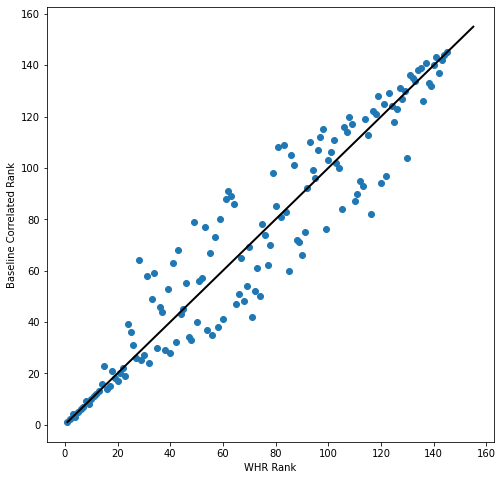

In [31]:
rank_range = [1,155]
plt.figure(figsize=[8,8])
plt.scatter(df_baseline_correlated['Ladder Rank'],df_baseline_correlated['Baseline Rank'])
plt.plot(rank_range, rank_range, 'k-', lw=2)
plt.xlabel('WHR Rank')
plt.ylabel('Baseline Correlated Rank')
plt.show()

(array([48., 25., 13.,  9., 14., 13., 11.,  7.,  3.,  2.]),
 array([ 0. ,  3.6,  7.2, 10.8, 14.4, 18. , 21.6, 25.2, 28.8, 32.4, 36. ]),
 <a list of 10 Patch objects>)

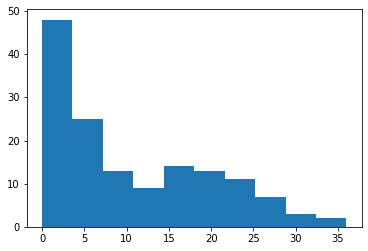

In [32]:
plt.hist(df_baseline_correlated['Baseline Rank Change (Abs)'])

(array([ 2., 11., 15., 11., 42., 29., 13.,  9., 10.,  3.]),
 array([-34., -27., -20., -13.,  -6.,   1.,   8.,  15.,  22.,  29.,  36.]),
 <a list of 10 Patch objects>)

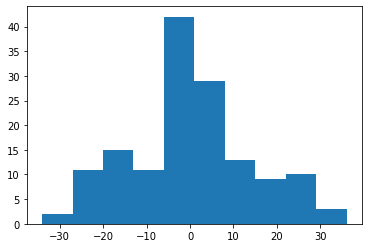

In [33]:
plt.hist(df_baseline_correlated['Baseline Rank Change'])

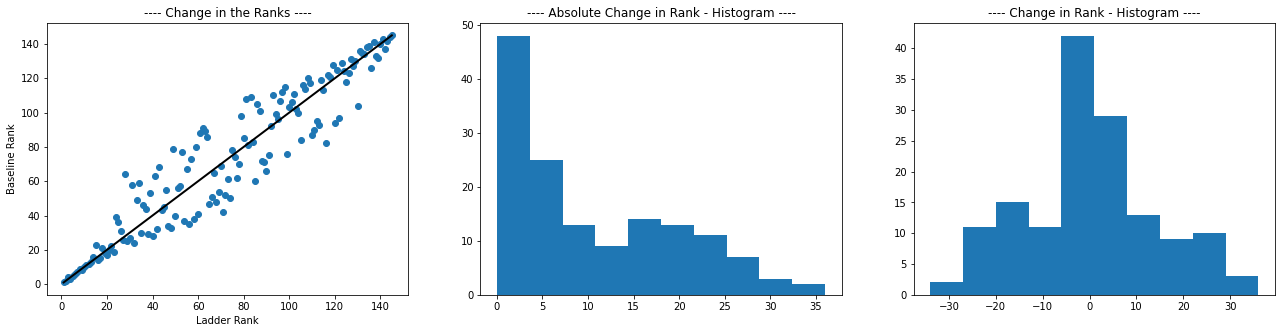

In [34]:
compareAnalysis(df_baseline_correlated)

In [35]:
# final_scores_all_countries['baseline_correlated'] = df_baseline_correlated['Baseline Score']
# final_scores_all_countries

In [36]:
final_scores_all_countries = pd.merge(final_scores_all_countries, df_baseline_correlated[['Country name','Baseline Score', 'Baseline Rank', 'Baseline Rank Change', 'Baseline Rank Change (Abs)']], 
         how='left', on='Country name')

In [37]:
replace_cols = {'Baseline Score': 'baseline_correlated_score',
                'Baseline Rank': 'baseline_correlated_rank',
                'Baseline Rank Change': 'baseline_correlated_rc',
                'Baseline Rank Change (Abs)': 'baseline_correlated_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0


# 5: Scoring Function 3: Baseline Weighted Rank
# (Ladder Score + Baseline Weighted Variables)


In [38]:
df_allFeatures = get_all_features()
df_allFeatures

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,3.0,5.6588,1.05790,42.000000,91.293808,0.1,81.7,27.1,6.8,20.8
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,4.0,4.1690,0.99982,37.430168,91.293808,0.4,80.8,28.2,5.2,13.2
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,5.0,2.6438,0.97046,32.500000,91.293808,1.9,83.6,32.3,6.9,15.8
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,4.0,5.9066,0.99461,38.095238,91.293808,1.9,82.9,27.8,4.7,21.7
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,2.0,5.1048,0.97754,41.420118,91.293808,4.4,82.3,27.5,6.5,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,149.0,Central African Republic,CF,Africa,Africa,Sub-Saharan Africa,Africa,829.0,126.9636,0.76095,8.571429,37.395821,0.1,52.8,56.2,6.0,18.0
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,150.0,Rwanda,RW,Africa,Africa,Sub-Saharan Africa,Africa,248.0,38.8520,1.01159,61.250000,73.215591,5.4,68.7,43.7,6.0,16.9
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,151.0,Zimbabwe,ZW,Africa,Africa,Sub-Saharan Africa,Africa,458.0,83.2486,0.97012,31.481481,88.693420,3.1,61.2,43.2,11.1,29.1
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,152.0,South Sudan,SS,Africa,Africa,Sub-Saharan Africa,Africa,1150.0,59.4332,0.68539,28.459530,34.522758,14.0,57.6,46.3,4.1,8.3


In [39]:
baseline_cols = ['Country name','Ladder score','school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate', 'life_expectancy']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
baseline_weighted = df_allFeatures[baseline_cols + baseline_cols_neg]

In [40]:
correlation_values = baseline_correlated.corr().iloc[0]
correlation_values

Ladder score                        1.000000
school_secondary_enrollment_gpi     0.336205
women_seats_parliament              0.327640
literacy_rate                       0.534331
life_expectancy                     0.760263
maternal_mortality_ratio_per100k   -0.631733
adolescent_fetility_per1k          -0.540611
natural_resource_depletion         -0.310049
income_inequality                  -0.353398
female_suicide_per100k             -0.246942
male_suicide_per100k                0.014560
Name: Ladder score, dtype: float64

In [41]:
df_allFeatures

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,3.0,5.6588,1.05790,42.000000,91.293808,0.1,81.7,27.1,6.8,20.8
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,4.0,4.1690,0.99982,37.430168,91.293808,0.4,80.8,28.2,5.2,13.2
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,5.0,2.6438,0.97046,32.500000,91.293808,1.9,83.6,32.3,6.9,15.8
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,4.0,5.9066,0.99461,38.095238,91.293808,1.9,82.9,27.8,4.7,21.7
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,2.0,5.1048,0.97754,41.420118,91.293808,4.4,82.3,27.5,6.5,13.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,149.0,Central African Republic,CF,Africa,Africa,Sub-Saharan Africa,Africa,829.0,126.9636,0.76095,8.571429,37.395821,0.1,52.8,56.2,6.0,18.0
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,150.0,Rwanda,RW,Africa,Africa,Sub-Saharan Africa,Africa,248.0,38.8520,1.01159,61.250000,73.215591,5.4,68.7,43.7,6.0,16.9
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,151.0,Zimbabwe,ZW,Africa,Africa,Sub-Saharan Africa,Africa,458.0,83.2486,0.97012,31.481481,88.693420,3.1,61.2,43.2,11.1,29.1
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,152.0,South Sudan,SS,Africa,Africa,Sub-Saharan Africa,Africa,1150.0,59.4332,0.68539,28.459530,34.522758,14.0,57.6,46.3,4.1,8.3


In [42]:
index = 1
for col in baseline_correlated.corr().columns[1:]:
    print(index, col, abs(correlation_values[index]))
    df_allFeatures[col] = df_allFeatures[col].apply(lambda x: x * abs(correlation_values[index]))
    index += 1

1 school_secondary_enrollment_gpi 0.33620544181273443
2 women_seats_parliament 0.32763955694052244
3 literacy_rate 0.5343308931872275
4 life_expectancy 0.7602630722535814
5 maternal_mortality_ratio_per100k 0.6317325246077797
6 adolescent_fetility_per1k 0.5406109617762127
7 natural_resource_depletion 0.31004938712707325
8 income_inequality 0.3533977295683886
9 female_suicide_per100k 0.2469422479701188
10 male_suicide_per100k 0.014560197263151857


In [43]:
df_allFeatures

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,1.895198,3.059209,0.355672,13.760861,48.781102,0.031005,62.113493,9.577078,1.679207,0.302852
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,2.526930,2.253807,0.336145,12.263604,48.781102,0.124020,61.429256,9.965816,1.284100,0.192195
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,3.158663,1.429267,0.326274,10.648286,48.781102,0.589094,63.557993,11.414747,1.703902,0.230051
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,2.526930,3.193173,0.334393,12.481507,48.781102,0.589094,63.025809,9.824457,1.160629,0.315956
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,1.263465,2.759711,0.328654,13.570869,48.781102,1.364217,62.569651,9.718438,1.605125,0.198019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,149.0,Central African Republic,CF,Africa,Africa,Sub-Saharan Africa,Africa,523.706263,68.637914,0.255836,2.808339,19.981742,0.031005,40.141890,19.860952,1.481653,0.262084
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445,150.0,Rwanda,RW,Africa,Africa,Sub-Saharan Africa,Africa,156.669666,21.003817,0.340102,20.067923,39.121352,1.674267,52.230073,15.443481,1.481653,0.246067
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031,151.0,Zimbabwe,ZW,Africa,Africa,Sub-Saharan Africa,Africa,289.333496,45.005106,0.326160,10.314579,47.391635,0.961153,46.528100,15.266782,2.741059,0.423702
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751,152.0,South Sudan,SS,Africa,Africa,Sub-Saharan Africa

In [44]:
from sklearn import preprocessing

df_baseline_weighted = df_allFeatures

# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate', 'life_expectancy', 'male_suicide_per100k']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'svg-id', 'Ladder score', 'Baseline Score', 'Ladder Rank', 'Baseline Rank', 'Baseline Rank Change']

# normalie basline variables
df_baseline_weighted[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_baseline_weighted[baseline_cols+baseline_cols_neg])

# get the baseline score
df_baseline_weighted['Baseline Score'] = df_baseline_weighted.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_baseline_weighted['Baseline Rank'] = df_baseline_weighted['Baseline Score'].rank(method='max',ascending = False)
df_baseline_weighted['Ladder Rank'] = df_baseline_weighted['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_baseline_weighted['Baseline Rank Change'] = df_baseline_weighted['Baseline Rank'] - df_baseline_weighted['Ladder Rank']
df_baseline_weighted['Baseline Rank Change (Abs)'] = abs(df_baseline_weighted['Baseline Rank Change'])

# save the data file
df_baseline_weighted.to_csv('baseline_weighted.csv')

In [45]:
print('Countries with most change in rank')
df_baseline_weighted.sort_values('Baseline Rank Change (Abs)',ascending=False).head(14)[display_cols]

Countries with most change in rank


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
28,Guatemala,GT,6.3989,6.286723,28.0,61.0,33.0
45,Nicaragua,NI,6.1371,6.051258,43.0,74.0,31.0
51,Philippines,PH,6.0060,5.966830,49.0,79.0,30.0
122,Ukraine,UA,4.5607,5.530100,116.0,86.0,-30.0
65,Pakistan,PK,5.6933,5.398102,62.0,92.0,30.0
137,Egypt,EG,4.1514,4.578977,130.0,102.0,-28.0
85,Benin,BJ,5.2160,4.281303,81.0,108.0,27.0
64,Bolivia,BO,5.7475,5.511425,61.0,88.0,27.0
115,Armenia,AM,4.6768,5.604244,110.0,84.0,-26.0
66,Paraguay,PY,5.6921,5.467222,63.0,89.0,26.0


In [46]:
print('Countries with least/no change in rank')
df_baseline_weighted.sort_values('Baseline Rank Change (Abs)').head(14)[display_cols]

Countries with least/no change in rank


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
0,Finland,FI,7.8087,9.157973,1.0,1.0,0.0
131,Eswatini,SZ,4.3081,3.463976,124.0,124.0,0.0
108,South Africa,ZA,4.8141,4.574642,103.0,103.0,0.0
151,South Sudan,SS,2.8166,1.844838,144.0,144.0,0.0
46,Romania,RO,6.1237,7.008574,44.0,44.0,0.0
13,Israel,IL,7.1286,8.355268,14.0,14.0,0.0
12,United Kingdom,GB,7.1645,8.374310,13.0,13.0,0.0
11,Australia,AU,7.2228,8.409699,12.0,12.0,0.0
10,Canada,CA,7.2321,8.420826,11.0,11.0,0.0
152,Afghanistan,AF,2.5669,1.659643,145.0,145.0,0.0


In [47]:
print('WHR20 Top 10')
df_baseline_weighted.sort_values('Ladder Rank').head(10)[display_cols]

WHR20 Top 10


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
0,Finland,FI,7.8087,9.157973,1.0,1.0,0.0
1,Denmark,DK,7.6456,8.979514,2.0,2.0,0.0
2,Switzerland,CH,7.5599,8.847794,3.0,3.0,0.0
3,Iceland,IS,7.5045,8.827245,4.0,5.0,1.0
4,Norway,NO,7.4880,8.827787,5.0,4.0,-1.0
5,Netherlands,NL,7.4489,8.769491,6.0,6.0,0.0
6,Sweden,SE,7.3535,8.696953,7.0,7.0,0.0
7,New Zealand,NZ,7.2996,8.440734,8.0,10.0,2.0
8,Austria,AT,7.2942,8.578057,9.0,8.0,-1.0
9,Luxembourg,LU,7.2375,8.463526,10.0,9.0,-1.0


In [48]:
print('Baseline Weighted Top 10')
df_baseline_weighted.sort_values('Baseline Rank').head(10)[display_cols]

Baseline Weighted Top 10


,Country name,svg-id,Ladder score,Baseline Score,Ladder Rank,Baseline Rank,Baseline Rank Change
0,Finland,FI,7.8087,9.157973,1.0,1.0,0.0
1,Denmark,DK,7.6456,8.979514,2.0,2.0,0.0
2,Switzerland,CH,7.5599,8.847794,3.0,3.0,0.0
4,Norway,NO,7.4880,8.827787,5.0,4.0,-1.0
3,Iceland,IS,7.5045,8.827245,4.0,5.0,1.0
5,Netherlands,NL,7.4489,8.769491,6.0,6.0,0.0
6,Sweden,SE,7.3535,8.696953,7.0,7.0,0.0
8,Austria,AT,7.2942,8.578057,9.0,8.0,-1.0
9,Luxembourg,LU,7.2375,8.463526,10.0,9.0,-1.0
7,New Zealand,NZ,7.2996,8.440734,8.0,10.0,2.0


In [49]:
df_baseline_weighted[abs(df_baseline_weighted['Baseline Rank Change'])>=10].shape

(61, 41)

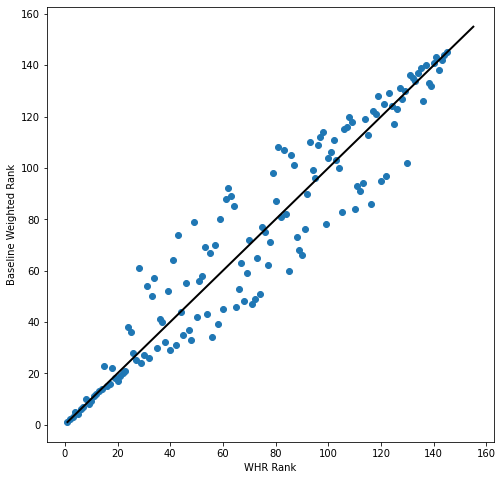

In [50]:
rank_range = [1,155]
plt.figure(figsize=[8,8])
plt.scatter(df_baseline_weighted['Ladder Rank'],df_baseline_weighted['Baseline Rank'])
plt.plot(rank_range, rank_range, 'k-', lw=2)
plt.xlabel('WHR Rank')
plt.ylabel('Baseline Weighted Rank')
plt.show()

(array([49., 22., 13., 14., 10.,  8., 13.,  8.,  3.,  5.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <a list of 10 Patch objects>)

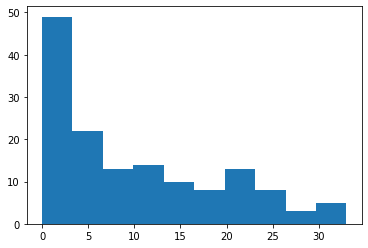

In [51]:
plt.hist(df_baseline_weighted['Baseline Rank Change (Abs)'])

(array([ 8., 12.,  6., 17., 42., 25., 15.,  7.,  7.,  6.]),
 array([-30. , -23.7, -17.4, -11.1,  -4.8,   1.5,   7.8,  14.1,  20.4,
         26.7,  33. ]),
 <a list of 10 Patch objects>)

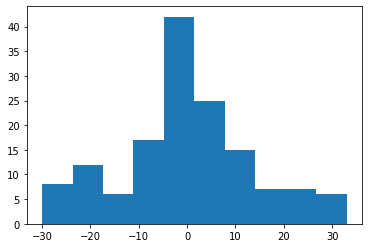

In [52]:
plt.hist(df_baseline_weighted['Baseline Rank Change'])

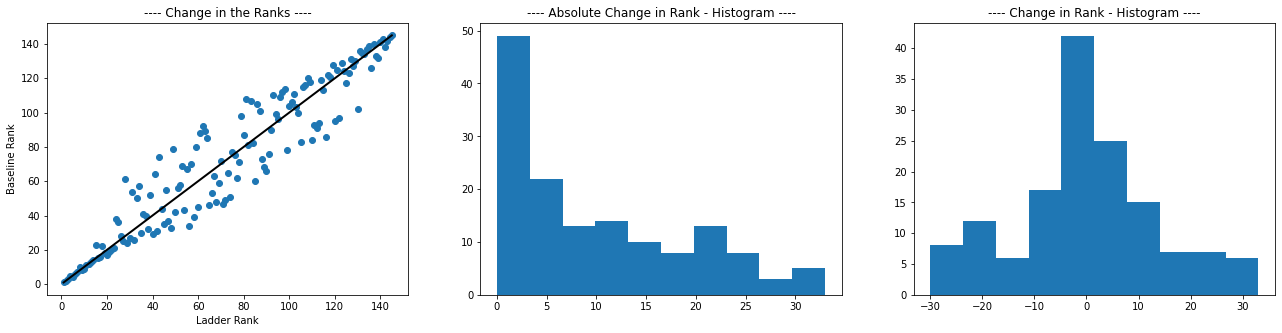

In [53]:
compareAnalysis(df_baseline_weighted)

In [54]:
final_scores_all_countries = pd.merge(final_scores_all_countries, df_baseline_weighted[['Country name','Baseline Score', 'Baseline Rank', 'Baseline Rank Change', 'Baseline Rank Change (Abs)']], 
         how='left', on='Country name')

In [55]:
replace_cols = {'Baseline Score': 'baseline_weighted_score',
                'Baseline Rank': 'baseline_weighted_rank',
                'Baseline Rank Change': 'baseline_weighted_rc',
                'Baseline Rank Change (Abs)': 'baseline_weighted_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0,9.157973,1.0,0.0,0.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0,8.979514,2.0,0.0,0.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0,8.847794,3.0,0.0,0.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0,8.827245,5.0,1.0,1.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0,8.827787,4.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0,2.438572,143.0,2.0,2.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0,2.824899,138.0,-4.0,4.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0,2.473738,142.0,-1.0,1.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0,1.844838,144.0,0.0,0.0


# Analysis for Group level data

In [56]:
# group the data by theor assigned groups
df_allfeatures_grouped = get_all_features().groupby("group").mean().reset_index()
df_allfeatures_grouped

,group,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Africa,4.437288,0.068593,4.571730,4.302846,8.015193,0.682397,56.025472,0.712049,-0.009160,0.768617,1.972317,0.471894,0.857238,0.389734,0.378113,0.192952,0.107800,2.039562,119.904762,433.619048,87.702993,0.953351,21.131777,65.717009,7.885714,63.354762,42.369048,7.609524,16.416667
1,Asia,5.224287,0.043481,5.309510,5.139065,9.200453,0.818773,65.180466,0.843538,0.078885,0.731958,1.972317,0.839249,1.179349,0.719328,0.535709,0.251181,0.131468,1.567998,85.291667,102.708333,32.281683,0.990427,18.844757,88.141188,3.200000,73.362500,35.745833,5.102083,12.504167
2,Balkan,5.544500,0.046441,5.635524,5.453476,9.822038,0.844148,68.481894,0.757592,-0.073797,0.889267,1.972317,1.031900,1.239283,0.838185,0.432699,0.150203,0.029904,1.822328,73.875000,10.250000,17.430450,1.001349,24.810253,96.614027,0.825000,77.325000,32.412500,3.575000,13.512500
3,Carribean,5.372925,0.101583,5.572028,5.173822,9.085616,0.826582,63.001528,0.780001,0.036173,0.810472,1.972317,0.803657,1.197794,0.640883,0.459557,0.222933,0.080777,1.967324,78.000000,180.500000,56.160050,0.995107,19.449294,83.715903,2.500000,71.350000,40.400000,3.700000,15.325000
4,Europe,6.224166,0.040261,6.303077,6.145254,10.245840,0.890252,69.758499,0.788340,-0.071233,0.682270,1.972317,1.163252,1.348178,0.884144,0.469552,0.151899,0.163548,2.043599,46.931034,9.620690,14.330090,0.999946,26.141690,95.161525,1.465517,78.627586,31.851724,4.548276,19.613793
5,Middle East,5.354975,0.050817,5.454576,5.255374,9.907420,0.811493,66.023695,0.724659,-0.058352,0.762567,1.972317,1.058364,1.162155,0.749686,0.393227,0.160418,0.111706,1.719416,82.500000,35.750000,27.068700,0.981788,14.558235,90.854438,3.508333,75.616667,35.875000,2.583333,6.366667
6,Nordic,7.560060,0.039067,7.636632,7.483488,10.806485,0.952758,72.620976,0.948881,0.099962,0.317948,1.972317,1.337016,1.495813,0.987198,0.661967,0.265121,0.398765,2.414166,3.800000,3.400000,5.192360,1.014368,41.015466,91.293808,1.400000,82.080000,27.960000,6.120000,17.020000
7,North America,6.544489,0.054072,6.650470,6.438507,9.539989,0.865087,68.525127,0.880756,-0.023672,0.726660,1.972317,0.944483,1.288740,0.839741,0.580317,0.183354,0.134888,2.572949,29.888889,49.444444,57.013667,1.010008,30.325427,90.150824,1.188889,76.800000,44.455556,3.411111,13.166667
8,Oceania,7.261200,0.040653,7.340880,7.181520,10.610770,0.946987,73.403584,0.925825,0.191029,0.318154,1.972317,1.276357,1.482182,1.015373,0.634334,0.325350,0.398632,2.128956,10.000000,7.500000,14.965200,1.003020,33.500000,91.293808,1.750000,82.700000,36.600000,6.100000,17.350000
9,South America,5.939710,0.052293,6.042205,5.837215,9.477927,0.874400,67.423274,0.817408,-0.116691,0.814078,1.972317,0.925248,1.310736,0.800073,0.504391,0.121834,0.078449,2.198968,54.800000,76.800000,63.809040,1.005114,27.071270,95.327104,3.080000,75.780000,44.790000,4.280000,13.310000


In [57]:
df_allfeatures_grouped_who = get_all_features().groupby("group_who").mean().reset_index()
df_allfeatures_grouped_who

,group_who,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Africa,4.394623,0.069613,4.531064,4.258182,7.912641,0.680856,55.332711,0.711986,0.004029,0.767431,1.972317,0.440109,0.853598,0.364793,0.378038,0.201675,0.108565,2.047850,121.307692,462.230769,93.314869,0.949602,21.018832,64.513696,8.271795,62.441026,42.815385,7.987179,17.279487
1,Americas,6.077791,0.061562,6.198452,5.957131,9.433984,0.862439,67.085435,0.835691,-0.053707,0.779244,1.972317,0.911629,1.282486,0.787910,0.526304,0.163490,0.100939,2.305022,49.086957,84.130435,59.819722,1.005289,27.019074,91.282264,2.239130,75.408696,43.895652,3.839130,13.604348
2,Eastern Mediterranean,4.934021,0.051598,5.035153,4.832890,9.423363,0.747054,63.172591,0.702117,-0.090634,0.771212,1.972317,0.908337,1.009953,0.647041,0.366209,0.139068,0.106124,1.757290,97.285714,97.571429,30.943957,0.949764,16.259832,82.696223,3.671429,73.121429,35.450000,2.628571,5.635714
3,Europe,6.192166,0.041405,6.273319,6.111013,10.109340,0.888460,69.358033,0.803142,-0.033675,0.690104,1.972317,1.120946,1.343945,0.869727,0.487292,0.176738,0.158490,2.035027,49.020000,10.540000,15.758044,0.999670,26.611845,95.333283,1.726000,78.106000,32.024000,4.400000,17.398000
4,South-East Asia,4.832537,0.047978,4.926575,4.738500,8.970359,0.785788,64.333207,0.867748,0.205776,0.782861,1.972317,0.767934,1.101439,0.688825,0.564726,0.335103,0.098603,1.275895,103.875000,132.125000,38.335925,1.036563,13.968610,83.826990,1.337500,72.862500,36.475000,6.725000,11.900000
5,Western Pacific,5.859364,0.041696,5.941088,5.777639,9.958880,0.868724,69.589975,0.879032,0.016665,0.602806,1.972317,1.074313,1.297331,0.878077,0.578250,0.210032,0.214852,1.606508,62.636364,47.454545,20.630364,1.006584,23.042069,93.304357,3.518182,77.863636,36.800000,4.931818,13.163636


In [58]:
df_allfeatures_grouped_wb = get_all_features().groupby("group_wb").mean().reset_index()
df_allfeatures_grouped_wb

,group_wb,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,East Asia and Pacific,5.717529,0.042278,5.800394,5.634663,9.809979,0.859909,68.132706,0.881436,0.109447,0.645611,1.972317,1.028163,1.276510,0.825613,0.581131,0.271394,0.187216,1.547501,68.571429,70.428571,24.766757,1.004685,20.623600,92.237532,3.207143,76.557143,36.964286,5.075000,12.692857
1,Europe and Central Asia,6.160560,0.041349,6.241605,6.079516,10.094076,0.887063,69.218779,0.801763,-0.041694,0.688870,1.972317,1.116215,1.340646,0.864714,0.485639,0.171435,0.159287,2.022624,50.312500,10.791667,15.962783,0.999304,26.898999,95.434732,1.756250,77.918750,31.935417,4.475000,17.737500
2,Latin America and Caribbean,5.981786,0.063247,6.105750,5.857821,9.303024,0.856891,66.717328,0.830684,-0.071901,0.801526,1.972317,0.871039,1.269381,0.774657,0.520302,0.151457,0.086553,2.308386,52.380952,90.761905,64.250610,1.005886,27.190014,91.281164,2.409524,74.914286,44.480952,3.623810,13.176190
3,Middle East and North Africa,5.314840,0.051503,5.415787,5.213893,9.764722,0.796444,65.658571,0.722489,-0.068059,0.752831,1.972317,1.014136,1.126610,0.736540,0.390626,0.153998,0.117992,1.774942,85.266667,47.266667,24.092413,0.988381,16.326005,88.186679,4.106667,75.600000,34.753333,2.573333,5.913333
4,North America,7.085850,0.043861,7.171817,6.999883,10.809069,0.920698,70.950550,0.888266,0.137331,0.545279,1.972317,1.337817,1.420089,0.927060,0.589318,0.289836,0.251993,2.269697,14.500000,14.500000,13.295400,0.999015,25.224206,91.293808,0.450000,80.600000,37.750000,6.100000,18.100000
5,South Asia,4.475443,0.047160,4.567876,4.383010,8.559491,0.708996,62.448662,0.771805,0.035106,0.790656,1.972317,0.640591,0.920061,0.620979,0.449734,0.222228,0.093571,1.528265,111.285714,195.857143,41.462629,0.969177,17.775240,72.541452,0.800000,71.314286,35.714286,6.028571,10.842857
6,Sub-Saharan Africa,4.378558,0.070280,4.516308,4.240808,7.869869,0.677632,55.054489,0.718443,0.007322,0.768272,1.972317,0.426853,0.845982,0.354777,0.385777,0.203853,0.108023,2.053298,121.868421,471.447368,95.511739,0.948354,20.894129,64.069113,8.244737,62.065789,43.215789,8.150000,17.605263


In [59]:
df_allfeatures_grouped_madd = get_all_features().groupby("group_madd").mean().reset_index()
df_allfeatures_grouped_madd

,group_madd,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k
0,Africa,4.455991,0.067406,4.588106,4.323875,8.084239,0.687533,56.439894,0.710545,-0.014936,0.769381,1.972317,0.493293,0.869368,0.404654,0.376310,0.189132,0.107307,2.015932,119.227273,414.886364,85.122561,0.955151,21.043735,66.593859,7.629545,63.852273,41.890909,7.384091,16.120455
1,East Asia,5.097426,0.044248,5.184152,5.010701,9.264979,0.795143,65.483755,0.836373,0.073470,0.733518,1.972317,0.859248,1.123537,0.730247,0.527122,0.247601,0.130461,1.479208,90.473684,123.263158,31.949611,0.991778,18.218794,85.080421,2.473684,73.978947,36.542105,5.318421,11.521053
2,Eastern Europe,5.646433,0.042693,5.730111,5.562755,9.671017,0.869346,66.772614,0.777465,-0.087291,0.804289,1.972317,0.985094,1.298798,0.776648,0.456517,0.141278,0.084769,1.903329,69.444444,14.925926,22.928200,0.997265,22.720066,97.214686,2.433333,75.044444,31.862963,4.122222,20.470370
3,Latin America,5.981786,0.063247,6.105750,5.857821,9.303024,0.856891,66.717328,0.830684,-0.071901,0.801526,1.972317,0.871039,1.269381,0.774657,0.520302,0.151457,0.086553,2.308386,52.380952,90.761905,64.250610,1.005886,27.190014,91.281164,2.409524,74.914286,44.480952,3.623810,13.176190
4,Western Asia,5.394930,0.052322,5.497480,5.292380,9.916680,0.819648,65.680197,0.720770,-0.054707,0.750681,1.972317,1.061234,1.181414,0.737319,0.388565,0.162828,0.119380,1.744184,80.700000,38.600000,26.727980,0.980173,14.190879,92.779119,3.800000,75.480000,36.470000,2.740000,6.200000
5,Western Europe,6.967405,0.039309,7.044451,6.890359,10.702537,0.917773,72.821632,0.857978,0.040858,0.523861,1.972317,1.304799,1.413181,0.994422,0.553016,0.226032,0.265822,2.210136,19.850000,4.900000,6.265600,1.003761,32.437201,92.778806,0.990000,82.105000,31.410000,4.975000,14.255000
6,Western Offshoots,7.173525,0.042257,7.256349,7.090701,10.709919,0.933842,72.177067,0.907045,0.164180,0.431717,1.972317,1.307087,1.451136,0.971216,0.611826,0.307593,0.325313,2.199327,12.250000,11.000000,14.130300,1.001017,29.362103,91.293808,1.100000,81.650000,37.175000,6.100000,17.725000


# 7: Scoring Function 6: Baseline Grouped Rank

In [60]:
df_allfeatures_grouped.columns

Index(['group', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'Ladder Rank',
       'maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k',
       'school_secondary_enrollment_gpi', 'women_seats_parliament',
       'literacy_rate', 'natural_resource_depletion', 'life_expectancy',
       'income_inequality', 'female_suicide_per100k', 'male_suicide_per100k'],
      dtype='object')

In [61]:
from sklearn import preprocessing

df_baseline_grouped = df_allfeatures_grouped

# rank variable names
scoring_name = 'Baseline Grouped Score'
scoring_rank = 'Baseline Grouped Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['group', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_baseline_grouped[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_baseline_grouped[baseline_cols+baseline_cols_neg])

# get the baseline score
df_baseline_grouped[scoring_name] = df_baseline_grouped.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_baseline_grouped[scoring_rank] = df_baseline_grouped[scoring_name].rank(method='max',ascending = False)
df_baseline_grouped[main_score_rank] = df_baseline_grouped['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_baseline_grouped[rank_change] = df_baseline_grouped[scoring_rank] - df_baseline_grouped[main_score_rank]
df_baseline_grouped[rank_change_abs] = abs(df_baseline_grouped[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_baseline_grouped

,group,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Baseline Grouped Score,Baseline Grouped Rank,Baseline Grouped Rank Change,Baseline Grouped Rank Change (Abs)
0,Africa,4.437288,0.068593,4.571730,4.302846,8.015193,0.682397,56.025472,0.712049,-0.009160,0.768617,1.972317,0.471894,0.857238,0.389734,0.378113,0.192952,0.107800,2.039562,10.0,0.963198,0.194815,0.002118,0.046940,0.145977,0.017517,63.354762,0.094114,0.016903,0.036466,3.309310,10.0,0.0,0.0
1,Asia,5.224287,0.043481,5.309510,5.139065,9.200453,0.818773,65.180466,0.843538,0.078885,0.731958,1.972317,0.839249,1.179349,0.719328,0.535709,0.251181,0.131468,1.567998,9.0,0.705629,0.221782,0.006804,0.129468,0.605549,0.021985,73.362500,0.245582,0.035052,0.085906,4.650173,8.0,-1.0,1.0
2,Balkan,5.544500,0.046441,5.635524,5.453476,9.822038,0.844148,68.481894,0.757592,-0.073797,0.889267,1.972317,1.031900,1.239283,0.838185,0.432699,0.150203,0.029904,1.822328,6.0,0.095143,0.161794,0.009295,0.230295,0.896794,0.007658,77.325000,0.300861,0.033184,0.125426,5.956819,5.0,-1.0,1.0
3,Carribean,5.372925,0.101583,5.572028,5.173822,9.085616,0.826582,63.001528,0.780001,0.036173,0.810472,1.972317,0.803657,1.197794,0.640883,0.459557,0.222933,0.080777,1.967324,7.0,0.850802,0.264715,0.004691,0.091676,0.394602,0.011784,71.350000,0.190429,0.017440,0.072236,4.456487,9.0,2.0,2.0
4,Europe,6.224166,0.040261,6.303077,6.145254,10.245840,0.890252,69.758499,0.788340,-0.071233,0.682270,1.972317,1.163252,1.348178,0.884144,0.469552,0.151899,0.163548,2.043599,4.0,0.089870,0.133861,0.009341,0.244197,0.888930,0.013690,78.627586,0.297536,0.042487,0.183218,6.605972,3.0,-1.0,1.0
5,Middle East,5.354975,0.050817,5.454576,5.255374,9.907420,0.811493,66.023695,0.724659,-0.058352,0.762567,1.972317,1.058364,1.162155,0.749686,0.393227,0.160418,0.111706,1.719416,8.0,0.328761,0.248927,0.009029,0.133879,0.835507,0.032263,75.616667,0.329910,0.023757,0.058549,5.311224,7.0,-1.0,1.0
6,Nordic,7.560060,0.039067,7.636632,7.483488,10.806485,0.952758,72.620976,0.948881,0.099962,0.317948,1.972317,1.337016,1.495813,0.987198,0.661967,0.265121,0.398765,2.414166,1.0,0.032174,0.049135,0.009599,0.388128,0.863910,0.013248,82.080000,0.264584,0.057913,0.161060,8.243582,1.0,0.0,0.0
7,North America,6.544489,0.054072,6.650470,6.438507,9.539989,0.865087,68.525127,0.880756,-0.023672,0.726660,1.972317,0.944483,1.288740,0.839741,0.580317,0.183354,0.134888,2.572949,3.0,0.380276,0.438491,0.007768,0.233232,0.693348,0.009144,76.800000,0.341907,0.026235,0.101265,6.181520,4.0,1.0,1.0
8,Oceania,7.261200,0.040653,7.340880,7.181520,10.610770,0.946987,73.403584,0.925825,0.191029,0.318154,1.972317,1.276357,1.482182,1.015373,0.634334,0.325350,0.398632,2.128956,2.0,0.070186,0.140046,0.009386,0.313497,0.854338,0.016377,82.700000,0.342507,0.057084,0.162363,7.649858,2.0,0.0,0.0
9,South America,5.939710,0.052293,6.042205,5.837215,9.477927,0.874400,67.423274,0.817408,-0.116691,0.814078,1.972317,0.925248,1.310736,0.800073,0.504391,0.121834,0.078449,2.198968,5.0,0.517761,0.430180,0.006776,0.182506,0.642665,0.020764,75.780000,0.301960,0.028854,0.089732,5.382405,6.0,1.0,1.0


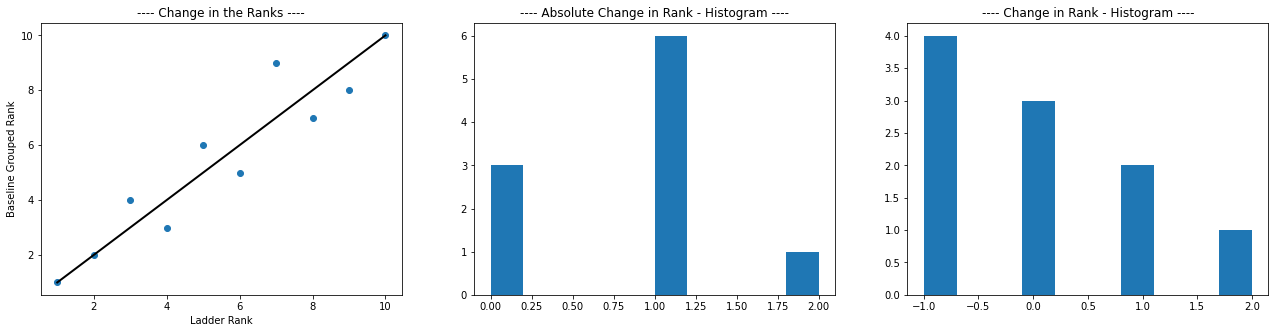

In [62]:
compareAnalysis(df_baseline_grouped)

# 8: Scoring Function 7: Baseline Weighted Grouped

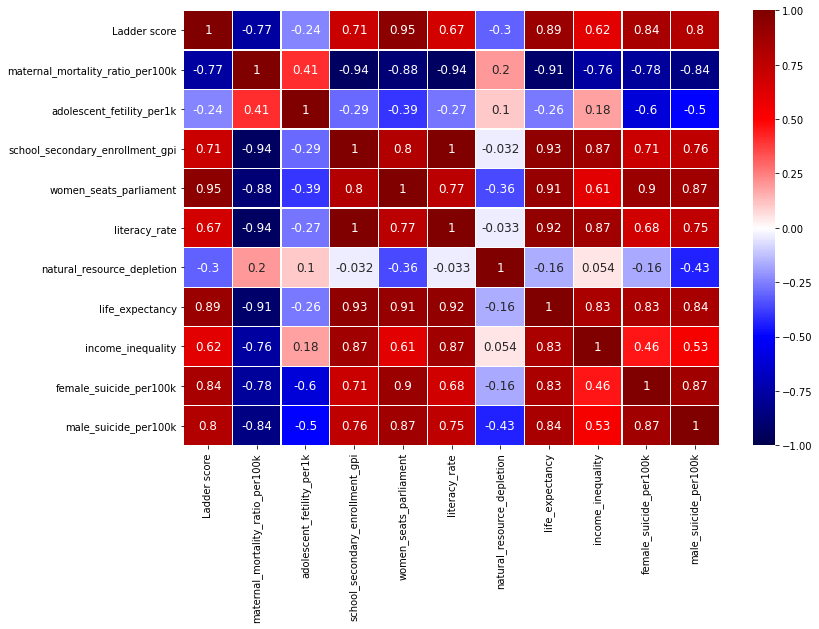

In [63]:
variable_to_check = ['Ladder score']
variables_to_consider = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k', 
                         'school_secondary_enrollment_gpi','women_seats_parliament','literacy_rate',
                         'natural_resource_depletion','life_expectancy','income_inequality', 
                         'female_suicide_per100k', 'male_suicide_per100k' ]
variables_to_consider = variable_to_check + variables_to_consider

getCorrelationPlot(df_baseline_grouped[variables_to_consider])

In [64]:
all_groups = df_baseline_grouped['group'].values.tolist()
df_allFeatures = get_all_features()

group_weights = {}
for group in all_groups:
    temp_dict = {}
    curr_group_weight = df_allFeatures[df_allFeatures['group']==group][variables_to_consider].corr().values.tolist()[0]
    for i,x in enumerate(curr_group_weight):
        temp_dict[variables_to_consider[i]+'_weight'] = x
    group_weights[group] = temp_dict

df_weightByGroup = pd.DataFrame(group_weights).transpose()
df_weightByGroup.index.names = ['group']
df_weightByGroup = df_weightByGroup.reset_index()
df_weightByGroup = df_weightByGroup.fillna(1)
df_weightByGroup

,group,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight
0,Africa,1.0,-0.392026,-0.141259,0.137503,-0.260036,0.118770,0.023154,0.319422,-0.303169,-0.159640,-0.128387
1,Asia,1.0,-0.763717,-0.228423,0.372678,0.045124,0.685564,0.273767,0.474315,-0.210405,-0.259242,0.100507
2,Balkan,1.0,0.041884,-0.249127,0.187844,-0.442073,0.413731,0.200582,0.452271,-0.337991,-0.061879,0.727001
3,Carribean,1.0,-0.991663,-0.046980,-0.295767,0.912260,0.961276,0.431676,0.970940,-0.263285,-0.723936,-0.178988
4,Europe,1.0,-0.722227,-0.666268,0.030507,0.474239,-0.580077,-0.286740,0.781029,-0.151381,0.410774,-0.206294
5,Middle East,1.0,-0.724819,-0.792251,0.392724,0.569401,0.368359,0.098396,0.739728,0.338016,-0.670700,-0.381985
6,Nordic,1.0,-0.168608,0.020448,0.324080,-0.407606,1.000000,-0.319397,-0.668113,-0.733058,-0.156418,0.307235
7,North America,1.0,-0.765347,-0.849084,-0.022725,0.146869,0.504290,-0.583550,0.828337,-0.536545,0.458695,0.272319
8,Oceania,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000
9,South America,1.0,-0.723996,-0.687168,0.181820,-0.208342,0.070170,0.112627,0.720098,0.470127,0.216357,0.561846


In [65]:
from sklearn import preprocessing

df_baseline_grouped_weighted = get_all_features()

# merge the weights by groups to the main data
df_baseline_grouped_weighted = df_baseline_grouped_weighted.merge(df_weightByGroup, how='left', on='group')

# rank variable names
scoring_name = 'Baseline Grouped Weighted Score'
scoring_rank = 'Baseline Grouped Weighted Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate','maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_baseline_grouped_weighted[baseline_cols] = preprocessing.normalize(df_baseline_grouped_weighted[baseline_cols])

# get the baseline score
weighted_scalar = 2.2
df_baseline_grouped_weighted[scoring_name] = df_baseline_grouped_weighted.apply(lambda x: x['Ladder score'] + sum([x[col]*x[col+'_weight']*weighted_scalar for col in baseline_cols]),axis=1)

# get the ranks
df_baseline_grouped_weighted[scoring_rank] = df_baseline_grouped_weighted[scoring_name].rank(method='max',ascending = False)
df_baseline_grouped_weighted[main_score_rank] = df_baseline_grouped_weighted['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_baseline_grouped_weighted[rank_change] = df_baseline_grouped_weighted[scoring_rank] - df_baseline_grouped_weighted[main_score_rank]
df_baseline_grouped_weighted[rank_change_abs] = abs(df_baseline_grouped_weighted[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_baseline_grouped_weighted

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight,Baseline Grouped Weighted Score,Baseline Grouped Weighted Rank,Baseline Grouped Weighted Rank Change,Baseline Grouped Weighted Rank Change (Abs)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,0.028154,0.053107,0.009928,0.394162,0.856775,0.000938,81.7,0.254328,0.063817,0.195204,1.0,-0.168608,0.020448,0.324080,-0.407606,1.000000,-0.319397,-0.668113,-0.733058,-0.156418,0.307235,9.038330,3.0,2.0,2.0
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,0.038550,0.040178,0.009636,0.360730,0.879835,0.003855,80.8,0.271775,0.050114,0.127214,1.0,-0.168608,0.020448,0.324080,-0.407606,1.000000,-0.319397,-0.668113,-0.733058,-0.156418,0.307235,8.879870,4.0,2.0,2.0
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,0.048184,0.025478,0.009352,0.313197,0.879784,0.018310,83.6,0.311270,0.066494,0.152262,1.0,-0.722227,-0.666268,0.030507,0.474239,-0.580077,-0.286740,0.781029,-0.151381,0.410774,-0.206294,6.526409,23.0,20.0,20.0
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,0.037954,0.056045,0.009437,0.361468,0.866245,0.018028,82.9,0.263781,0.044596,0.205901,1.0,-0.168608,0.020448,0.324080,-0.407606,1.000000,-0.319397,-0.668113,-0.733058,-0.156418,0.307235,8.767020,5.0,1.0,1.0
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,0.018997,0.048488,0.009285,0.393426,0.867147,0.041793,82.3,0.261207,0.061740,0.129179,1.0,-0.168608,0.020448,0.324080,-0.407606,1.000000,-0.319397,-0.668113,-0.733058,-0.156418,0.307235,8.660126,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,141.0,Centra

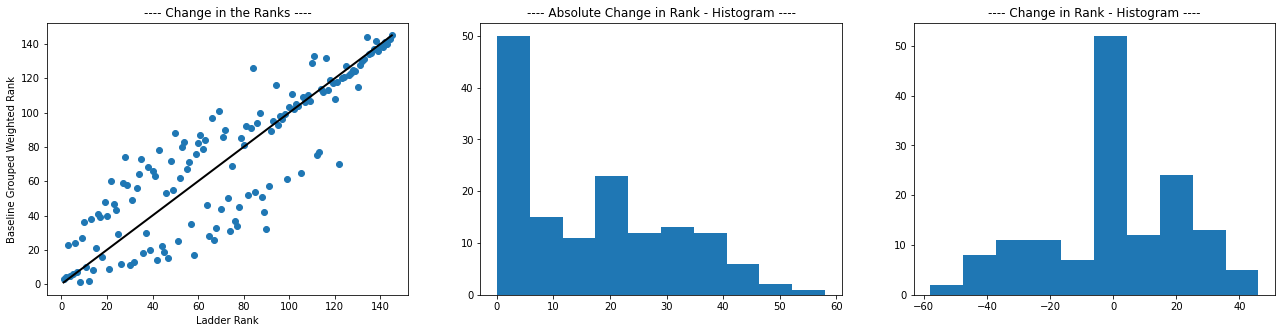

In [66]:
compareAnalysis(df_baseline_grouped_weighted, show_top_tables=False)

In [67]:
df_baseline_grouped_weighted[df_baseline_grouped_weighted['Baseline Grouped Weighted Score'].isnull()]

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight,Baseline Grouped Weighted Score,Baseline Grouped Weighted Rank,Baseline Grouped Weighted Rank Change,Baseline Grouped Weighted Rank Change (Abs)


In [68]:
final_scores_all_countries = pd.merge(final_scores_all_countries, 
                                      df_baseline_grouped_weighted[['Country name',
                                                              'Baseline Grouped Weighted Score',
                                                              'Baseline Grouped Weighted Rank', 
                                                              'Baseline Grouped Weighted Rank Change', 
                                                              'Baseline Grouped Weighted Rank Change (Abs)']], 
          how='left', on='Country name')


In [69]:
replace_cols = {'Baseline Grouped Weighted Score': 'gCustom_weighted_score',
                'Baseline Grouped Weighted Rank': 'gCustom_weighted_rank',
                'Baseline Grouped Weighted Rank Change': 'gCustom_weighted_rc',
                'Baseline Grouped Weighted Rank Change (Abs)': 'gCustom_weighted_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc,gCustom_weighted_score,gCustom_weighted_rank,gCustom_weighted_rc,gCustom_weighted_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0,9.157973,1.0,0.0,0.0,9.038330,3.0,2.0,2.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0,8.979514,2.0,0.0,0.0,8.879870,4.0,2.0,2.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0,8.847794,3.0,0.0,0.0,6.526409,23.0,20.0,20.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0,8.827245,5.0,1.0,1.0,8.767020,5.0,1.0,1.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0,8.827787,4.0,-1.0,1.0,8.660126,6.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0,2.438572,143.0,2.0,2.0,2.532492,138.0,-3.0,3.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0,2.824899,138.0,-4.0,4.0,2.295511,141.0,-1.0,1.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0,2.473738,142.0,-1.0,1.0,2.344647,140.0,-3.0,3.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0,1.844838,144.0,0.0,0.0,1.905164,143.0,-1.0,1.0


# 9: Scoring Function 8: WHO Grouped Rank

In [70]:
df_allfeatures_grouped_who.columns

Index(['group_who', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'Ladder Rank',
       'maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k',
       'school_secondary_enrollment_gpi', 'women_seats_parliament',
       'literacy_rate', 'natural_resource_depletion', 'life_expectancy',
       'income_inequality', 'female_suicide_per100k', 'male_suicide_per100k'],
      dtype='object')

In [71]:
from sklearn import preprocessing

df_who_grouped = df_allfeatures_grouped_who

# rank variable names
scoring_name = 'WHO Grouped Score'
scoring_rank = 'WHO Grouped Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['group', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_who_grouped[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_who_grouped[baseline_cols+baseline_cols_neg])

# get the baseline score
df_who_grouped[scoring_name] = df_who_grouped.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_who_grouped[scoring_rank] = df_who_grouped[scoring_name].rank(method='max',ascending = False)
df_who_grouped[main_score_rank] = df_who_grouped['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_who_grouped[rank_change] = df_who_grouped[scoring_rank] - df_who_grouped[main_score_rank]
df_who_grouped[rank_change_abs] = abs(df_who_grouped[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_who_grouped

,group_who,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,WHO Grouped Score,WHO Grouped Rank,WHO Grouped Rank Change,WHO Grouped Rank Change (Abs)
0,Africa,4.394623,0.069613,4.531064,4.258182,7.912641,0.680856,55.332711,0.711986,0.004029,0.767431,1.972317,0.440109,0.853598,0.364793,0.378038,0.201675,0.108565,2.047850,6.0,0.965428,0.194900,0.001983,0.043900,0.134745,0.017277,62.441026,0.089425,0.016682,0.036090,3.255450,6.0,0.0,0.0
1,Americas,6.077791,0.061562,6.198452,5.957131,9.433984,0.862439,67.085435,0.835691,-0.053707,0.779244,1.972317,0.911629,1.282486,0.787910,0.526304,0.163490,0.100939,2.305022,2.0,0.569132,0.404673,0.006801,0.182781,0.617513,0.015147,75.408696,0.296948,0.025971,0.092032,5.480982,3.0,1.0,1.0
2,Eastern Mediterranean,4.934021,0.051598,5.035153,4.832890,9.423363,0.747054,63.172591,0.702117,-0.090634,0.771212,1.972317,0.908337,1.009953,0.647041,0.366209,0.139068,0.106124,1.757290,4.0,0.709906,0.225141,0.006910,0.118303,0.601678,0.026712,73.121429,0.257926,0.019125,0.041004,4.381098,4.0,0.0,0.0
3,Europe,6.192166,0.041405,6.273319,6.111013,10.109340,0.888460,69.358033,0.803142,-0.033675,0.690104,1.972317,1.120946,1.343945,0.869727,0.487292,0.176738,0.158490,2.035027,1.0,0.098254,0.146896,0.009319,0.248075,0.888694,0.016090,78.106000,0.298527,0.041017,0.162184,6.575287,1.0,0.0,0.0
4,South-East Asia,4.832537,0.047978,4.926575,4.738500,8.970359,0.785788,64.333207,0.867748,0.205776,0.782861,1.972317,0.767934,1.101439,0.688825,0.564726,0.335103,0.098603,1.275895,5.0,0.794309,0.230468,0.006232,0.083976,0.503951,0.008041,72.862500,0.219280,0.040429,0.071540,4.062629,5.0,0.0,0.0
5,Western Pacific,5.859364,0.041696,5.941088,5.777639,9.958880,0.868724,69.589975,0.879032,0.016665,0.602806,1.972317,1.074313,1.297331,0.878077,0.578250,0.210032,0.214852,1.606508,3.0,0.408735,0.177693,0.008670,0.198466,0.803649,0.030303,77.863636,0.316966,0.042479,0.113381,5.780591,2.0,-1.0,1.0


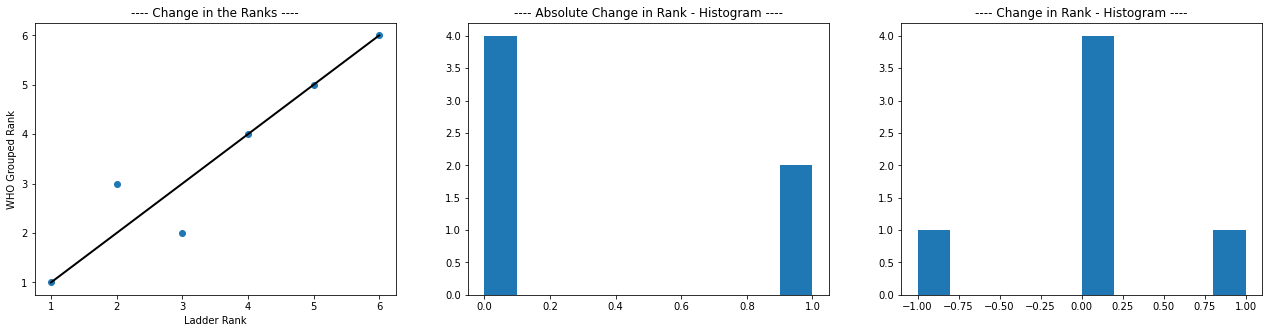

In [72]:
compareAnalysis(df_who_grouped)

# 10: Scoring Function 9: WHO Weighted Grouped

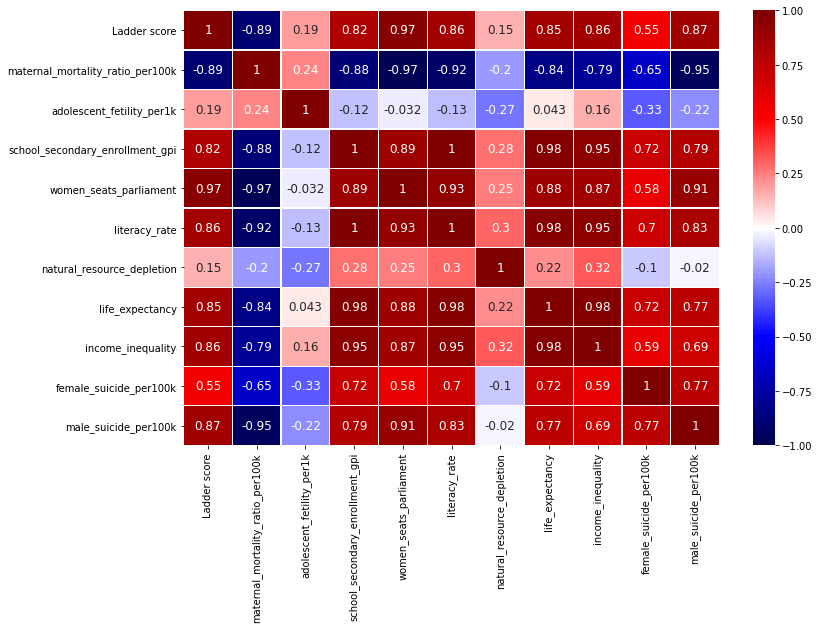

In [73]:
variable_to_check = ['Ladder score']
variables_to_consider = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k', 
                         'school_secondary_enrollment_gpi','women_seats_parliament','literacy_rate',
                         'natural_resource_depletion','life_expectancy','income_inequality', 
                         'female_suicide_per100k', 'male_suicide_per100k' ]
variables_to_consider = variable_to_check + variables_to_consider

getCorrelationPlot(df_who_grouped[variables_to_consider])

In [74]:
all_groups = df_who_grouped['group_who'].values.tolist()
df_allFeatures = get_all_features()

group_weights = {}
for group in all_groups:
    temp_dict = {}
    curr_group_weight = df_allFeatures[df_allFeatures['group_who']==group][variables_to_consider].corr().values.tolist()[0]
    for i,x in enumerate(curr_group_weight):
        temp_dict[variables_to_consider[i]+'_weight'] = x
    group_weights[group] = temp_dict

df_weightByGroup = pd.DataFrame(group_weights).transpose()
df_weightByGroup.index.names = ['group_who']
df_weightByGroup = df_weightByGroup.reset_index()
df_weightByGroup = df_weightByGroup.fillna(1)
df_weightByGroup

,group_who,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight
0,Africa,1.0,-0.349997,-0.041880,0.130823,-0.256051,0.063603,0.060625,0.259569,-0.288951,-0.115415,-0.034542
1,Americas,1.0,-0.874488,-0.382270,0.150382,0.358828,0.568281,-0.098511,0.858140,0.062480,-0.074457,0.076668
2,Eastern Mediterranean,1.0,-0.681084,-0.701461,0.529051,-0.023273,0.525730,0.475436,0.562236,0.164782,-0.451889,-0.683704
3,Europe,1.0,-0.504373,-0.605588,0.192290,0.555599,-0.582268,-0.172121,0.729703,-0.302723,0.452425,-0.024223
4,South-East Asia,1.0,-0.315319,0.404042,-0.497004,0.082082,0.470007,0.220516,0.506223,-0.085912,-0.773903,-0.149657
5,Western Pacific,1.0,-0.528735,-0.261883,-0.067795,0.589978,0.108482,-0.145229,0.571016,-0.058117,0.261836,0.359965


In [75]:
from sklearn import preprocessing

df_who_grouped_weighted = get_all_features()

# merge the weights by groups to the main data
df_who_grouped_weighted = df_who_grouped_weighted.merge(df_weightByGroup, how='left', on='group_who')

# rank variable names
scoring_name = 'WHO Grouped Weighted Score'
scoring_rank = 'WHO Grouped Weighted Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate','maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_who_grouped_weighted[baseline_cols] = preprocessing.normalize(df_who_grouped_weighted[baseline_cols])

# get the baseline score
weighted_scalar = 2.2
df_who_grouped_weighted[scoring_name] = df_who_grouped_weighted.apply(lambda x: x['Ladder score'] + sum([x[col]*x[col+'_weight']*weighted_scalar for col in baseline_cols]),axis=1)

# get the ranks
df_who_grouped_weighted[scoring_rank] = df_who_grouped_weighted[scoring_name].rank(method='max',ascending = False)
df_who_grouped_weighted[main_score_rank] = df_who_grouped_weighted['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_who_grouped_weighted[rank_change] = df_who_grouped_weighted[scoring_rank] - df_who_grouped_weighted[main_score_rank]
df_who_grouped_weighted[rank_change_abs] = abs(df_who_grouped_weighted[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_who_grouped_weighted

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight,WHO Grouped Weighted Score,WHO Grouped Weighted Rank,WHO Grouped Weighted Rank Change,WHO Grouped Weighted Rank Change (Abs)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,0.028154,0.053107,0.009928,0.394162,0.856775,0.000938,81.7,0.254328,0.063817,0.195204,1.0,-0.504373,-0.605588,0.192290,0.555599,-0.582268,-0.172121,0.729703,-0.302723,0.452425,-0.024223,6.978558,9.0,8.0,8.0
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,0.038550,0.040178,0.009636,0.360730,0.879835,0.003855,80.8,0.271775,0.050114,0.127214,1.0,-0.504373,-0.605588,0.192290,0.555599,-0.582268,-0.172121,0.729703,-0.302723,0.452425,-0.024223,6.727881,15.0,13.0,13.0
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,0.048184,0.025478,0.009352,0.313197,0.879784,0.018310,83.6,0.311270,0.066494,0.152262,1.0,-0.504373,-0.605588,0.192290,0.555599,-0.582268,-0.172121,0.729703,-0.302723,0.452425,-0.024223,6.576113,17.0,14.0,14.0
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,0.037954,0.056045,0.009437,0.361468,0.866245,0.018028,82.9,0.263781,0.044596,0.205901,1.0,-0.504373,-0.605588,0.192290,0.555599,-0.582268,-0.172121,0.729703,-0.302723,0.452425,-0.024223,6.574801,18.0,14.0,14.0
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,0.018997,0.048488,0.009285,0.393426,0.867147,0.041793,82.3,0.261207,0.061740,0.129179,1.0,-0.504373,-0.605588,0.192290,0.555599,-0.582268,-0.172121,0.729703,-0.302723,0.452425,-0.024223,6.641116,16.0,11.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,141.0,Central African R

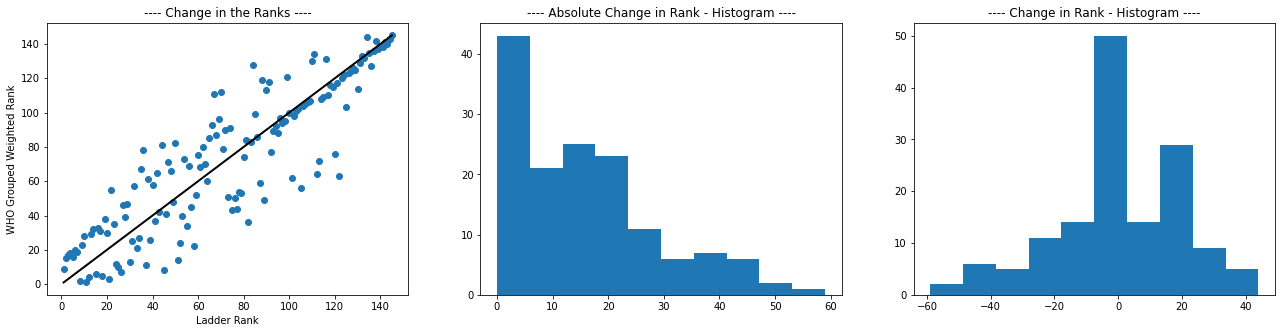

In [76]:
compareAnalysis(df_who_grouped_weighted, show_top_tables=False)

In [77]:
# df_baseline_grouped_weighted[df_baseline_grouped_weighted['Baseline Grouped Weighted Score'].isnull()]

In [78]:
final_scores_all_countries = pd.merge(final_scores_all_countries, 
                                      df_who_grouped_weighted[['Country name',
                                                              'WHO Grouped Weighted Score',
                                                              'WHO Grouped Weighted Rank', 
                                                              'WHO Grouped Weighted Rank Change', 
                                                              'WHO Grouped Weighted Rank Change (Abs)']], 
          how='left', on='Country name')


In [79]:
replace_cols = {'WHO Grouped Weighted Score': 'gWHO_weighted_score',
                'WHO Grouped Weighted Rank': 'gWHO_weighted_rank',
                'WHO Grouped Weighted Rank Change': 'gWHO_weighted_rc',
                'WHO Grouped Weighted Rank Change (Abs)': 'gWHO_weighted_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc,gCustom_weighted_score,gCustom_weighted_rank,gCustom_weighted_rc,gCustom_weighted_arc,gWHO_weighted_score,gWHO_weighted_rank,gWHO_weighted_rc,gWHO_weighted_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0,9.157973,1.0,0.0,0.0,9.038330,3.0,2.0,2.0,6.978558,9.0,8.0,8.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0,8.979514,2.0,0.0,0.0,8.879870,4.0,2.0,2.0,6.727881,15.0,13.0,13.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0,8.847794,3.0,0.0,0.0,6.526409,23.0,20.0,20.0,6.576113,17.0,14.0,14.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0,8.827245,5.0,1.0,1.0,8.767020,5.0,1.0,1.0,6.574801,18.0,14.0,14.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0,8.827787,4.0,-1.0,1.0,8.660126,6.0,1.0,1.0,6.641116,16.0,11.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0,2.438572,143.0,2.0,2.0,2.532492,138.0,-3.0,3.0,2.658442,138.0,-3.0,3.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0,2.824899,138.0,-4.0,4.0,2.295511,141.0,-1.0,1.0,2.401645,141.0,-1.0,1.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0,2.473738,142.0,-1.0,1.0,2.344647,140.0,-3.0,3.0,2.467562,140.0,-3.0,3.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0,1.844838,144.0,0.0,0.0,1.905164,143.0,-1.0,1.0,2.009280,143.0,-1.0,1.0


# 11: Scoring Function 10: WB Grouped Rank

In [80]:
df_allfeatures_grouped_wb.columns

Index(['group_wb', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'Ladder Rank',
       'maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k',
       'school_secondary_enrollment_gpi', 'women_seats_parliament',
       'literacy_rate', 'natural_resource_depletion', 'life_expectancy',
       'income_inequality', 'female_suicide_per100k', 'male_suicide_per100k'],
      dtype='object')

In [81]:
from sklearn import preprocessing

df_wb_grouped = df_allfeatures_grouped_wb

# rank variable names
scoring_name = 'WB Grouped Score'
scoring_rank = 'WB Grouped Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['group_wb', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_wb_grouped[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_wb_grouped[baseline_cols+baseline_cols_neg])

# get the baseline score
df_wb_grouped[scoring_name] = df_wb_grouped.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_wb_grouped[scoring_rank] = df_wb_grouped[scoring_name].rank(method='max',ascending = False)
df_wb_grouped[main_score_rank] = df_wb_grouped['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_wb_grouped[rank_change] = df_wb_grouped[scoring_rank] - df_wb_grouped[main_score_rank]
df_wb_grouped[rank_change_abs] = abs(df_wb_grouped[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_wb_grouped

,group_wb,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,WB Grouped Score,WB Grouped Rank,WB Grouped Rank Change,WB Grouped Rank Change (Abs)
0,East Asia and Pacific,5.717529,0.042278,5.800394,5.634663,9.809979,0.859909,68.132706,0.881436,0.109447,0.645611,1.972317,1.028163,1.276510,0.825613,0.581131,0.271394,0.187216,1.547501,4.0,0.555552,0.195364,0.007925,0.162682,0.727585,0.025298,76.557143,0.291580,0.040032,0.100123,5.407770,3.0,-1.0,1.0
1,Europe and Central Asia,6.160560,0.041349,6.241605,6.079516,10.094076,0.887063,69.218779,0.801763,-0.041694,0.688870,1.972317,1.116215,1.340646,0.864714,0.485639,0.171435,0.159287,2.022624,2.0,0.100366,0.148459,0.009294,0.250170,0.887574,0.016334,77.918750,0.297010,0.041619,0.164965,6.538846,2.0,0.0,0.0
2,Latin America and Caribbean,5.981786,0.063247,6.105750,5.857821,9.303024,0.856891,66.717328,0.830684,-0.071901,0.801526,1.972317,0.871039,1.269381,0.774657,0.520302,0.151457,0.086553,2.308386,3.0,0.590690,0.418151,0.006546,0.176956,0.594070,0.015681,74.914286,0.289488,0.023584,0.085752,5.336010,4.0,1.0,1.0
3,Middle East and North Africa,5.314840,0.051503,5.415787,5.213893,9.764722,0.796444,65.658571,0.722489,-0.068059,0.752831,1.972317,1.014136,1.126610,0.736540,0.390626,0.153998,0.117992,1.774942,5.0,0.429250,0.218794,0.008976,0.148264,0.800862,0.037294,75.600000,0.315610,0.023370,0.053702,5.194922,5.0,0.0,0.0
4,North America,7.085850,0.043861,7.171817,6.999883,10.809069,0.920698,70.950550,0.888266,0.137331,0.545279,1.972317,1.337817,1.420089,0.927060,0.589318,0.289836,0.251993,2.269697,1.0,0.137326,0.125917,0.009461,0.238892,0.864619,0.004262,80.600000,0.357520,0.057771,0.171420,7.344606,1.0,0.0,0.0
5,South Asia,4.475443,0.047160,4.567876,4.383010,8.559491,0.708996,62.448662,0.771805,0.035106,0.790656,1.972317,0.640591,0.920061,0.620979,0.449734,0.222228,0.093571,1.528265,6.0,0.902573,0.191073,0.004466,0.081914,0.334295,0.003687,71.314286,0.164583,0.027782,0.049967,3.556452,6.0,0.0,0.0
6,Sub-Saharan Africa,4.378558,0.070280,4.516308,4.240808,7.869869,0.677632,55.054489,0.718443,0.007322,0.768272,1.972317,0.426853,0.845982,0.354777,0.385777,0.203853,0.108023,2.053298,7.0,0.965887,0.195682,0.001943,0.042807,0.131263,0.016892,62.065789,0.088539,0.016697,0.036069,3.234805,7.0,0.0,0.0


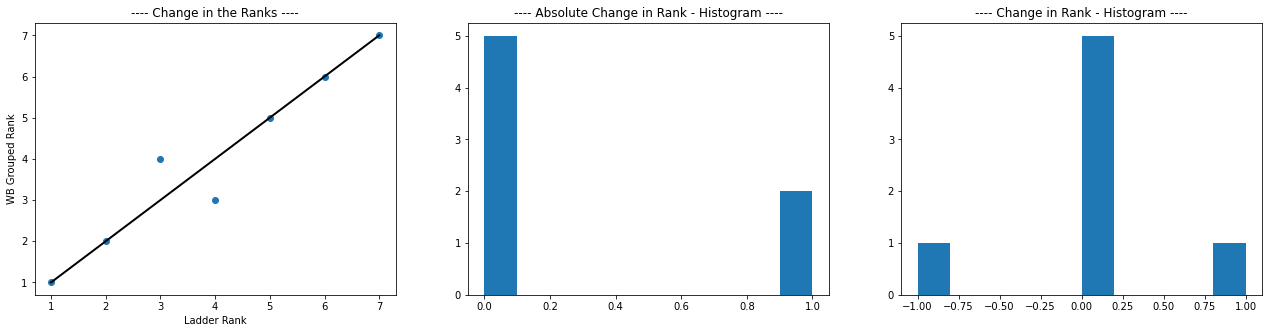

In [82]:
compareAnalysis(df_wb_grouped)

# 12: Scoring Function 11: WB Weighted Grouped

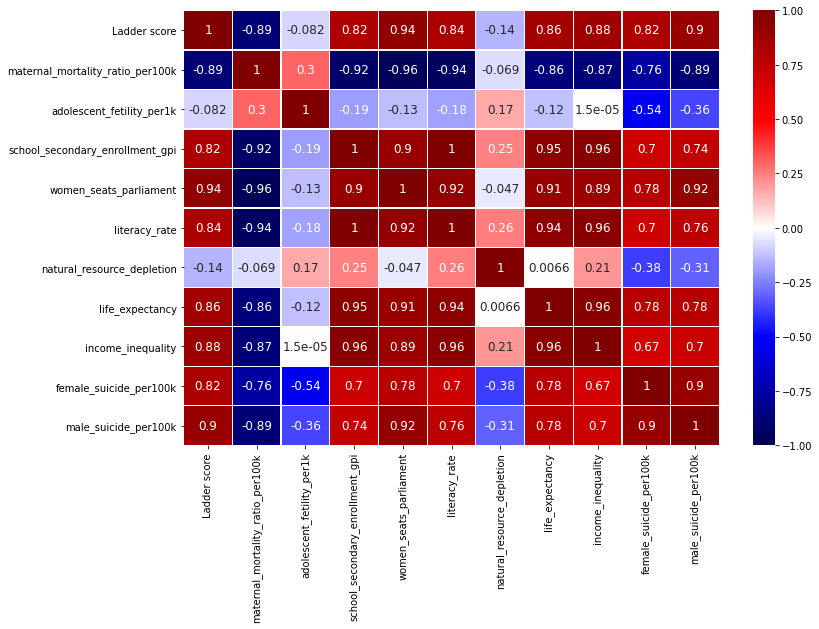

In [83]:
variable_to_check = ['Ladder score']
variables_to_consider = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k', 
                         'school_secondary_enrollment_gpi','women_seats_parliament','literacy_rate',
                         'natural_resource_depletion','life_expectancy','income_inequality', 
                         'female_suicide_per100k', 'male_suicide_per100k' ]
variables_to_consider = variable_to_check + variables_to_consider

getCorrelationPlot(df_wb_grouped[variables_to_consider])

In [84]:
all_groups = df_wb_grouped['group_wb'].values.tolist()
df_allFeatures = get_all_features()

group_weights = {}
for group in all_groups:
    temp_dict = {}
    curr_group_weight = df_allFeatures[df_allFeatures['group_wb']==group][variables_to_consider].corr().values.tolist()[0]
    for i,x in enumerate(curr_group_weight):
        temp_dict[variables_to_consider[i]+'_weight'] = x
    group_weights[group] = temp_dict

df_weightByGroup = pd.DataFrame(group_weights).transpose()
df_weightByGroup.index.names = ['group_wb']
df_weightByGroup = df_weightByGroup.reset_index()
df_weightByGroup = df_weightByGroup.fillna(1)
df_weightByGroup

,group_wb,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight
0,East Asia and Pacific,1.0,-0.676789,-0.269946,-0.080447,0.541094,0.399878,-0.101649,0.681058,-0.139730,-0.059294,0.476357
1,Europe and Central Asia,1.0,-0.493466,-0.602976,0.181637,0.602593,-0.572328,-0.162904,0.719822,-0.345784,0.505953,0.005909
2,Latin America and Caribbean,1.0,-0.887813,-0.095126,0.205210,0.423142,0.637723,0.027072,0.824355,0.306100,-0.264202,-0.013300
3,Middle East and North Africa,1.0,-0.673148,-0.644525,0.273245,0.260385,0.447464,0.103442,0.707232,0.223756,-0.533252,-0.129760
4,North America,1.0,-1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000
5,South Asia,1.0,-0.726504,-0.074882,0.475042,-0.097088,0.422271,0.439562,0.422519,-0.404602,-0.185525,-0.490923
6,Sub-Saharan Africa,1.0,-0.330441,0.009925,0.120348,-0.268189,0.044266,0.057758,0.219750,-0.258512,-0.092478,0.018320


In [85]:
from sklearn import preprocessing

df_wb_grouped_weighted = get_all_features()

# merge the weights by groups to the main data
df_wb_grouped_weighted = df_wb_grouped_weighted.merge(df_weightByGroup, how='left', on='group_wb')

# rank variable names
scoring_name = 'WB Grouped Weighted Score'
scoring_rank = 'WB Grouped Weighted Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate','maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_wb_grouped_weighted[baseline_cols] = preprocessing.normalize(df_wb_grouped_weighted[baseline_cols])

# get the baseline score
weighted_scalar = 2.2
df_wb_grouped_weighted[scoring_name] = df_wb_grouped_weighted.apply(lambda x: x['Ladder score'] + sum([x[col]*x[col+'_weight']*weighted_scalar for col in baseline_cols]),axis=1)

# get the ranks
df_wb_grouped_weighted[scoring_rank] = df_wb_grouped_weighted[scoring_name].rank(method='max',ascending = False)
df_wb_grouped_weighted[main_score_rank] = df_wb_grouped_weighted['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_wb_grouped_weighted[rank_change] = df_wb_grouped_weighted[scoring_rank] - df_wb_grouped_weighted[main_score_rank]
df_wb_grouped_weighted[rank_change_abs] = abs(df_wb_grouped_weighted[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_wb_grouped_weighted

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight,WB Grouped Weighted Score,WB Grouped Weighted Rank,WB Grouped Weighted Rank Change,WB Grouped Weighted Rank Change (Abs)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,0.028154,0.053107,0.009928,0.394162,0.856775,0.000938,81.7,0.254328,0.063817,0.195204,1.0,-0.493466,-0.602976,0.181637,0.602593,-0.572328,-0.162904,0.719822,-0.345784,0.505953,0.005909,7.035174,14.0,13.0,13.0
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,0.038550,0.040178,0.009636,0.360730,0.879835,0.003855,80.8,0.271775,0.050114,0.127214,1.0,-0.493466,-0.602976,0.181637,0.602593,-0.572328,-0.162904,0.719822,-0.345784,0.505953,0.005909,6.774012,19.0,17.0,17.0
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,0.048184,0.025478,0.009352,0.313197,0.879784,0.018310,83.6,0.311270,0.066494,0.152262,1.0,-0.493466,-0.602976,0.181637,0.602593,-0.572328,-0.162904,0.719822,-0.345784,0.505953,0.005909,6.617623,25.0,22.0,22.0
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,0.037954,0.056045,0.009437,0.361468,0.866245,0.018028,82.9,0.263781,0.044596,0.205901,1.0,-0.493466,-0.602976,0.181637,0.602593,-0.572328,-0.162904,0.719822,-0.345784,0.505953,0.005909,6.626404,24.0,20.0,20.0
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,0.018997,0.048488,0.009285,0.393426,0.867147,0.041793,82.3,0.261207,0.061740,0.129179,1.0,-0.493466,-0.602976,0.181637,0.602593,-0.572328,-0.162904,0.719822,-0.345784,0.505953,0.005909,6.693207,22.0,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,141.0,Central African Republi

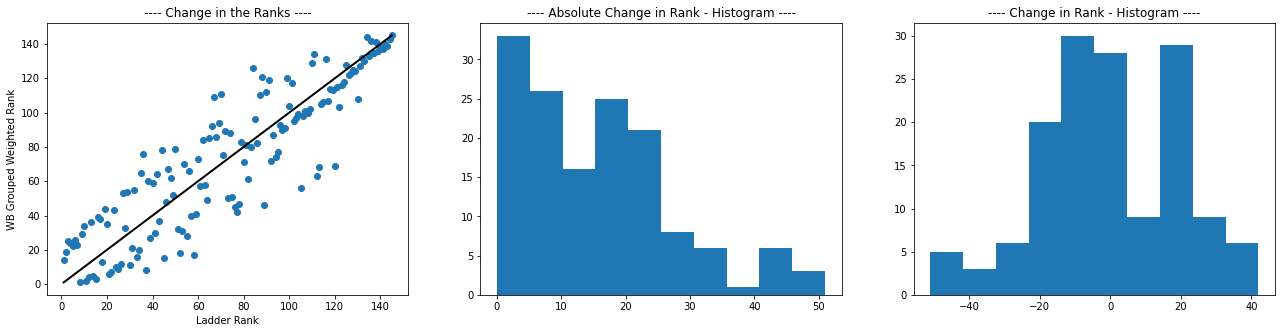

In [86]:
compareAnalysis(df_wb_grouped_weighted, show_top_tables=False)

In [87]:
# df_baseline_grouped_weighted[df_baseline_grouped_weighted['Baseline Grouped Weighted Score'].isnull()]

In [88]:
final_scores_all_countries = pd.merge(final_scores_all_countries, 
                                      df_wb_grouped_weighted[['Country name',
                                                              'WB Grouped Weighted Score',
                                                              'WB Grouped Weighted Rank', 
                                                              'WB Grouped Weighted Rank Change', 
                                                              'WB Grouped Weighted Rank Change (Abs)']], 
          how='left', on='Country name')


In [89]:
replace_cols = {'WB Grouped Weighted Score': 'gWB_weighted_score',
                'WB Grouped Weighted Rank': 'gWB_weighted_rank',
                'WB Grouped Weighted Rank Change': 'gWB_weighted_rc',
                'WB Grouped Weighted Rank Change (Abs)': 'gWB_weighted_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc,gCustom_weighted_score,gCustom_weighted_rank,gCustom_weighted_rc,gCustom_weighted_arc,gWHO_weighted_score,gWHO_weighted_rank,gWHO_weighted_rc,gWHO_weighted_arc,gWB_weighted_score,gWB_weighted_rank,gWB_weighted_rc,gWB_weighted_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0,9.157973,1.0,0.0,0.0,9.038330,3.0,2.0,2.0,6.978558,9.0,8.0,8.0,7.035174,14.0,13.0,13.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0,8.979514,2.0,0.0,0.0,8.879870,4.0,2.0,2.0,6.727881,15.0,13.0,13.0,6.774012,19.0,17.0,17.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0,8.847794,3.0,0.0,0.0,6.526409,23.0,20.0,20.0,6.576113,17.0,14.0,14.0,6.617623,25.0,22.0,22.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0,8.827245,5.0,1.0,1.0,8.767020,5.0,1.0,1.0,6.574801,18.0,14.0,14.0,6.626404,24.0,20.0,20.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0,8.827787,4.0,-1.0,1.0,8.660126,6.0,1.0,1.0,6.641116,16.0,11.0,11.0,6.693207,22.0,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0,2.438572,143.0,2.0,2.0,2.532492,138.0,-3.0,3.0,2.658442,138.0,-3.0,3.0,2.723146,137.0,-4.0,4.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0,2.824899,138.0,-4.0,4.0,2.295511,141.0,-1.0,1.0,2.401645,141.0,-1.0,1.0,2.458419,140.0,-2.0,2.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0,2.473738,142.0,-1.0,1.0,2.344647,140.0,-3.0,3.0,2.467562,140.0,-3.0,3.0,2.533209,139.0,-4.0,4.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0,1.844838,144.0,0.0,0.0,1.905164,143.0,-1.0,1.0,2.009280,143.0,-1.0,1.0,2.059727,143.0,-1.0,1.0


# 13: Scoring Function 12: Madd Grouped Rank

In [90]:
df_allfeatures_grouped_madd.columns

Index(['group_madd', 'Ladder score', 'Standard error of ladder score',
       'upperwhisker', 'lowerwhisker', 'Logged GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Ladder score in Dystopia',
       'Explained by: Log GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia + residual', 'Ladder Rank',
       'maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k',
       'school_secondary_enrollment_gpi', 'women_seats_parliament',
       'literacy_rate', 'natural_resource_depletion', 'life_expectancy',
       'income_inequality', 'female_suicide_per100k', 'male_suicide_per100k'],
      dtype='object')

In [91]:
from sklearn import preprocessing

df_madd_grouped = df_allfeatures_grouped_madd

# rank variable names
scoring_name = 'Madd Grouped Score'
scoring_rank = 'Madd Grouped Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate']
baseline_cols_neg = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['group_madd', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_madd_grouped[baseline_cols+baseline_cols_neg] = preprocessing.normalize(df_madd_grouped[baseline_cols+baseline_cols_neg])

# get the baseline score
df_madd_grouped[scoring_name] = df_madd_grouped.apply(lambda x: sum(x[rank_cols]) - sum(x[baseline_cols_neg]),axis=1)
df_madd_grouped[scoring_rank] = df_madd_grouped[scoring_name].rank(method='max',ascending = False)
df_madd_grouped[main_score_rank] = df_madd_grouped['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_madd_grouped[rank_change] = df_madd_grouped[scoring_rank] - df_madd_grouped[main_score_rank]
df_madd_grouped[rank_change_abs] = abs(df_madd_grouped[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_madd_grouped

,group_madd,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Madd Grouped Score,Madd Grouped Rank,Madd Grouped Rank Change,Madd Grouped Rank Change (Abs)
0,Africa,4.455991,0.067406,4.588106,4.323875,8.084239,0.687533,56.439894,0.710545,-0.014936,0.769381,1.972317,0.493293,0.869368,0.404654,0.376310,0.189132,0.107307,2.015932,7.0,0.961007,0.197171,0.002212,0.048744,0.154252,0.017672,63.852273,0.097033,0.017104,0.037340,3.333873,7.0,0.0,0.0
1,East Asia,5.097426,0.044248,5.184152,5.010701,9.264979,0.795143,65.483755,0.836373,0.073470,0.733518,1.972317,0.859248,1.123537,0.730247,0.527122,0.247601,0.130461,1.479208,6.0,0.775123,0.200911,0.006237,0.114566,0.535016,0.015555,73.978947,0.229790,0.033444,0.072449,4.425974,6.0,0.0,0.0
2,Eastern Europe,5.646433,0.042693,5.730111,5.562755,9.671017,0.869346,66.772614,0.777465,-0.087291,0.804289,1.972317,0.985094,1.298798,0.776648,0.456517,0.141278,0.084769,1.903329,4.0,0.135280,0.207807,0.009039,0.205921,0.881095,0.022054,75.044444,0.288787,0.037361,0.185531,5.865668,3.0,-1.0,1.0
3,Latin America,5.981786,0.063247,6.105750,5.857821,9.303024,0.856891,66.717328,0.830684,-0.071901,0.801526,1.972317,0.871039,1.269381,0.774657,0.520302,0.151457,0.086553,2.308386,3.0,0.590690,0.418151,0.006546,0.176956,0.594070,0.015681,74.914286,0.289488,0.023584,0.085752,5.336010,4.0,1.0,1.0
4,Western Asia,5.394930,0.052322,5.497480,5.292380,9.916680,0.819648,65.680197,0.720770,-0.054707,0.750681,1.972317,1.061234,1.181414,0.737319,0.388565,0.162828,0.119380,1.744184,5.0,0.346567,0.239975,0.008800,0.127412,0.833010,0.034118,75.480000,0.327443,0.024601,0.055666,5.335782,5.0,0.0,0.0
5,Western Europe,6.967405,0.039309,7.044451,6.890359,10.702537,0.917773,72.821632,0.857978,0.040858,0.523861,1.972317,1.304799,1.413181,0.994422,0.553016,0.226032,0.265822,2.210136,2.0,0.046848,0.059904,0.009597,0.310125,0.887039,0.009465,82.105000,0.300304,0.047565,0.136289,7.573790,1.0,-1.0,1.0
6,Western Offshoots,7.173525,0.042257,7.256349,7.090701,10.709919,0.933842,72.177067,0.907045,0.164180,0.431717,1.972317,1.307087,1.451136,0.971216,0.611826,0.307593,0.325313,2.199327,1.0,0.103695,0.133204,0.009436,0.276792,0.860614,0.010370,81.650000,0.350444,0.057504,0.167091,7.498060,2.0,1.0,1.0


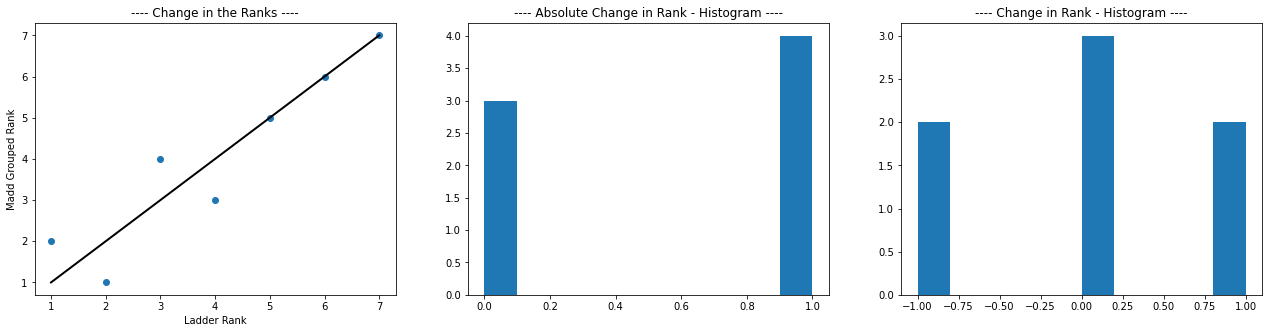

In [92]:
compareAnalysis(df_madd_grouped)

# 14: Scoring Function 13: Madd Weighted Grouped

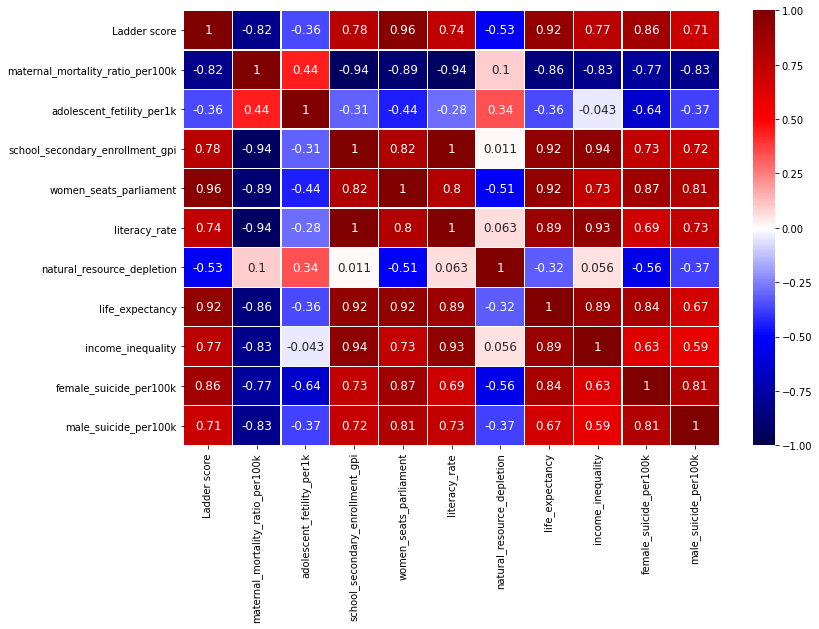

In [93]:
variable_to_check = ['Ladder score']
variables_to_consider = ['maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k', 
                         'school_secondary_enrollment_gpi','women_seats_parliament','literacy_rate',
                         'natural_resource_depletion','life_expectancy','income_inequality', 
                         'female_suicide_per100k', 'male_suicide_per100k' ]
variables_to_consider = variable_to_check + variables_to_consider

getCorrelationPlot(df_madd_grouped[variables_to_consider])

In [94]:
all_groups = df_madd_grouped['group_madd'].values.tolist()
df_allFeatures = get_all_features()

group_weights = {}
for group in all_groups:
    temp_dict = {}
    curr_group_weight = df_allFeatures[df_allFeatures['group_madd']==group][variables_to_consider].corr().values.tolist()[0]
    for i,x in enumerate(curr_group_weight):
        temp_dict[variables_to_consider[i]+'_weight'] = x
    group_weights[group] = temp_dict

df_weightByGroup = pd.DataFrame(group_weights).transpose()
df_weightByGroup.index.names = ['group_madd']
df_weightByGroup = df_weightByGroup.reset_index()
df_weightByGroup = df_weightByGroup.fillna(1)
df_weightByGroup

,group_madd,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight
0,Africa,1.0,-0.401879,-0.188091,0.142276,-0.239032,0.168700,-0.011073,0.350386,-0.316472,-0.166831,-0.127975
1,East Asia,1.0,-0.764001,-0.252487,0.408050,0.014093,0.665515,0.150856,0.573238,-0.099702,-0.289347,-0.041318
2,Eastern Europe,1.0,-0.301096,-0.368654,-0.071068,0.118084,-0.016323,-0.044647,0.434396,-0.238521,0.316082,0.258531
3,Latin America,1.0,-0.887813,-0.095126,0.205210,0.423142,0.637723,0.027072,0.824355,0.306100,-0.264202,-0.013300
4,Western Asia,1.0,-0.756203,-0.752811,0.454459,0.602150,0.195947,0.189282,0.703091,0.306170,-0.793950,-0.406695
5,Western Europe,1.0,-0.198805,-0.232932,0.240656,0.422375,-0.729363,0.222180,-0.042246,-0.771563,0.652279,0.605827
6,Western Offshoots,1.0,-0.905763,-0.379899,0.339523,0.764202,1.000000,0.333656,0.897071,-0.807007,-0.647434,-0.849983


In [95]:
from sklearn import preprocessing

df_madd_grouped_weighted = get_all_features()

# merge the weights by groups to the main data
df_madd_grouped_weighted = df_madd_grouped_weighted.merge(df_weightByGroup, how='left', on='group_madd')

# rank variable names
scoring_name = 'Madd Grouped Weighted Score'
scoring_rank = 'Madd Grouped Weighted Rank'
main_score_rank = 'Ladder Rank'
rank_change = scoring_rank + ' Change'
rank_change_abs = scoring_rank + ' Change (Abs)'


# get the baseline score columns
# differentiate them by type, as baselines need to be normalized
WHR20_cols =  ['Ladder score']
baseline_cols = ['school_secondary_enrollment_gpi', 'women_seats_parliament',\
               'literacy_rate','maternal_mortality_ratio_per100k', 'adolescent_fetility_per1k','natural_resource_depletion','income_inequality','female_suicide_per100k', 'male_suicide_per100k']
rank_cols = WHR20_cols + baseline_cols
display_cols = ['Country name', 'Ladder score']
display_cols.extend([scoring_name, scoring_rank, main_score_rank, rank_change, rank_change_abs])

# normalie basline variables
df_madd_grouped_weighted[baseline_cols] = preprocessing.normalize(df_madd_grouped_weighted[baseline_cols])

# get the baseline score
weighted_scalar = 2.2
df_madd_grouped_weighted[scoring_name] = df_madd_grouped_weighted.apply(lambda x: x['Ladder score'] + sum([x[col]*x[col+'_weight']*weighted_scalar for col in baseline_cols]),axis=1)

# get the ranks
df_madd_grouped_weighted[scoring_rank] = df_madd_grouped_weighted[scoring_name].rank(method='max',ascending = False)
df_madd_grouped_weighted[main_score_rank] = df_madd_grouped_weighted['Ladder score'].rank(method='max',ascending = False)

# get the change in rank and change magnitude
df_madd_grouped_weighted[rank_change] = df_madd_grouped_weighted[scoring_rank] - df_madd_grouped_weighted[main_score_rank]
df_madd_grouped_weighted[rank_change_abs] = abs(df_madd_grouped_weighted[rank_change])

# save the data file
# df_baseline_grouped.to_csv('baseline_group.csv')
df_madd_grouped_weighted

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual,Ladder Rank,country,svg-id,group,group_who,group_wb,group_madd,maternal_mortality_ratio_per100k,adolescent_fetility_per1k,school_secondary_enrollment_gpi,women_seats_parliament,literacy_rate,natural_resource_depletion,life_expectancy,income_inequality,female_suicide_per100k,male_suicide_per100k,Ladder score_weight,maternal_mortality_ratio_per100k_weight,adolescent_fetility_per1k_weight,school_secondary_enrollment_gpi_weight,women_seats_parliament_weight,literacy_rate_weight,natural_resource_depletion_weight,life_expectancy_weight,income_inequality_weight,female_suicide_per100k_weight,male_suicide_per100k_weight,Madd Grouped Weighted Score,Madd Grouped Weighted Rank,Madd Grouped Weighted Rank Change,Madd Grouped Weighted Rank Change (Abs)
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835,1.0,Finland,FI,Nordic,Europe,Europe and Central Asia,Western Europe,0.028154,0.053107,0.009928,0.394162,0.856775,0.000938,81.7,0.254328,0.063817,0.195204,1.0,-0.198805,-0.232932,0.240656,0.422375,-0.729363,0.222180,-0.042246,-0.771563,0.652279,0.605827,6.686414,19.0,18.0,18.0
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741,2.0,Denmark,DK,Nordic,Europe,Europe and Central Asia,Western Europe,0.038550,0.040178,0.009636,0.360730,0.879835,0.003855,80.8,0.271775,0.050114,0.127214,1.0,-0.198805,-0.232932,0.240656,0.422375,-0.729363,0.222180,-0.042246,-0.771563,0.652279,0.605827,6.318699,25.0,23.0,23.0
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267,3.0,Switzerland,CH,Europe,Europe,Europe and Central Asia,Western Europe,0.048184,0.025478,0.009352,0.313197,0.879784,0.018310,83.6,0.311270,0.066494,0.152262,1.0,-0.198805,-0.232932,0.240656,0.422375,-0.729363,0.222180,-0.042246,-0.771563,0.652279,0.605827,6.188997,32.0,29.0,29.0
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688,4.0,Iceland,IS,Nordic,Europe,Europe and Central Asia,Western Europe,0.037954,0.056045,0.009437,0.361468,0.866245,0.018028,82.9,0.263781,0.044596,0.205901,1.0,-0.198805,-0.232932,0.240656,0.422375,-0.729363,0.222180,-0.042246,-0.771563,0.652279,0.605827,6.309570,26.0,22.0,22.0
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266,5.0,Norway,NO,Nordic,Europe,Europe and Central Asia,Western Europe,0.018997,0.048488,0.009285,0.393426,0.867147,0.041793,82.3,0.261207,0.061740,0.129179,1.0,-0.198805,-0.232932,0.240656,0.422375,-0.729363,0.222180,-0.042246,-0.771563,0.652279,0.605827,6.271733,27.0,22.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198,141.0,Central African

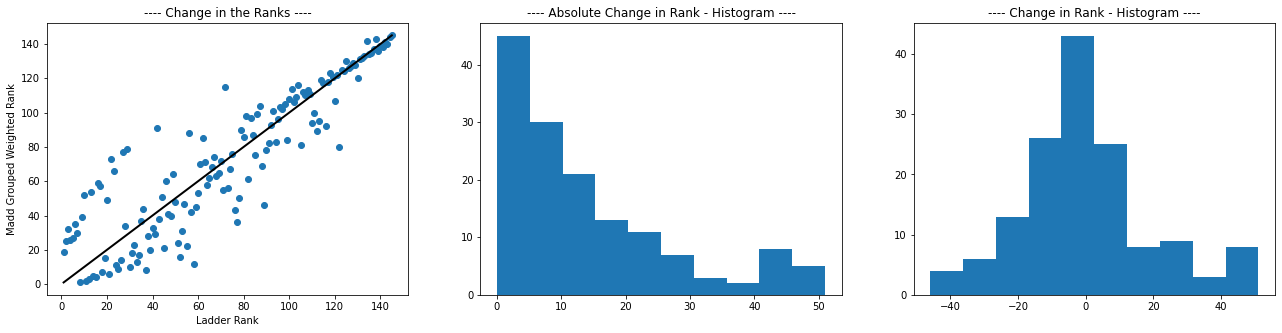

In [96]:
compareAnalysis(df_madd_grouped_weighted, show_top_tables=False)

In [97]:
# df_baseline_grouped_weighted[df_baseline_grouped_weighted['Baseline Grouped Weighted Score'].isnull()]

In [98]:
final_scores_all_countries = pd.merge(final_scores_all_countries, 
                                      df_madd_grouped_weighted[['Country name',
                                                              'Madd Grouped Weighted Score',
                                                              'Madd Grouped Weighted Rank', 
                                                              'Madd Grouped Weighted Rank Change', 
                                                              'Madd Grouped Weighted Rank Change (Abs)']], 
          how='left', on='Country name')


In [99]:
replace_cols = {'Madd Grouped Weighted Score': 'gMadd_weighted_score',
                'Madd Grouped Weighted Rank': 'gMadd_weighted_rank',
                'Madd Grouped Weighted Rank Change': 'gMadd_weighted_rc',
                'Madd Grouped Weighted Rank Change (Abs)': 'gMadd_weighted_arc'}
final_scores_all_countries = final_scores_all_countries.rename(columns=replace_cols)
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc,gCustom_weighted_score,gCustom_weighted_rank,gCustom_weighted_rc,gCustom_weighted_arc,gWHO_weighted_score,gWHO_weighted_rank,gWHO_weighted_rc,gWHO_weighted_arc,gWB_weighted_score,gWB_weighted_rank,gWB_weighted_rc,gWB_weighted_arc,gMadd_weighted_score,gMadd_weighted_rank,gMadd_weighted_rc,gMadd_weighted_arc
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0,9.157973,1.0,0.0,0.0,9.038330,3.0,2.0,2.0,6.978558,9.0,8.0,8.0,7.035174,14.0,13.0,13.0,6.686414,19.0,18.0,18.0
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0,8.979514,2.0,0.0,0.0,8.879870,4.0,2.0,2.0,6.727881,15.0,13.0,13.0,6.774012,19.0,17.0,17.0,6.318699,25.0,23.0,23.0
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0,8.847794,3.0,0.0,0.0,6.526409,23.0,20.0,20.0,6.576113,17.0,14.0,14.0,6.617623,25.0,22.0,22.0,6.188997,32.0,29.0,29.0
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0,8.827245,5.0,1.0,1.0,8.767020,5.0,1.0,1.0,6.574801,18.0,14.0,14.0,6.626404,24.0,20.0,20.0,6.309570,26.0,22.0,22.0
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0,8.827787,4.0,-1.0,1.0,8.660126,6.0,1.0,1.0,6.641116,16.0,11.0,11.0,6.693207,22.0,17.0,17.0,6.271733,27.0,22.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0,2.438572,143.0,2.0,2.0,2.532492,138.0,-3.0,3.0,2.658442,138.0,-3.0,3.0,2.723146,137.0,-4.0,4.0,2.498902,138.0,-3.0,3.0
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0,2.824899,138.0,-4.0,4.0,2.295511,141.0,-1.0,1.0,2.401645,141.0,-1.0,1.0,2.458419,140.0,-2.0,2.0,2.294556,141.0,-1.0,1.0
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0,2.473738,142.0,-1.0,1.0,2.344647,140.0,-3.0,3.0,2.467562,140.0,-3.0,3.0,2.533209,139.0,-4.0,4.0,2.325931,140.0,-3.0,3.0
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0,1.844838,144.0,0.0,0.0,1.905164,143.0,-1.0,1.0,2.009280,143.0,-1.0,1.0,2.059727,143.0,-1.0,1.0,1.880538,144.0,0.0,0.0


In [100]:
final_scores_all_countries = pd.merge(final_scores_all_countries, get_all_features()[['Country name', 'svg-id']], how='left', on='Country name')
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc,gCustom_weighted_score,gCustom_weighted_rank,gCustom_weighted_rc,gCustom_weighted_arc,gWHO_weighted_score,gWHO_weighted_rank,gWHO_weighted_rc,gWHO_weighted_arc,gWB_weighted_score,gWB_weighted_rank,gWB_weighted_rc,gWB_weighted_arc,gMadd_weighted_score,gMadd_weighted_rank,gMadd_weighted_rc,gMadd_weighted_arc,svg-id
0,Finland,7.8087,8.474017,1.0,0.0,0.0,9.254968,1.0,0.0,0.0,9.157973,1.0,0.0,0.0,9.038330,3.0,2.0,2.0,6.978558,9.0,8.0,8.0,7.035174,14.0,13.0,13.0,6.686414,19.0,18.0,18.0,FI
1,Denmark,7.6456,8.364114,2.0,0.0,0.0,9.027645,2.0,0.0,0.0,8.979514,2.0,0.0,0.0,8.879870,4.0,2.0,2.0,6.727881,15.0,13.0,13.0,6.774012,19.0,17.0,17.0,6.318699,25.0,23.0,23.0,DK
2,Switzerland,7.5599,8.140235,5.0,2.0,2.0,8.876328,4.0,1.0,1.0,8.847794,3.0,0.0,0.0,6.526409,23.0,20.0,20.0,6.576113,17.0,14.0,14.0,6.617623,25.0,22.0,22.0,6.188997,32.0,29.0,29.0,CH
3,Iceland,7.5045,8.115344,6.0,2.0,2.0,8.926532,3.0,-1.0,1.0,8.827245,5.0,1.0,1.0,8.767020,5.0,1.0,1.0,6.574801,18.0,14.0,14.0,6.626404,24.0,20.0,20.0,6.309570,26.0,22.0,22.0,IS
4,Norway,7.4880,8.196455,3.0,-2.0,2.0,8.865572,5.0,0.0,0.0,8.827787,4.0,-1.0,1.0,8.660126,6.0,1.0,1.0,6.641116,16.0,11.0,11.0,6.693207,22.0,17.0,17.0,6.271733,27.0,22.0,22.0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.4759,2.300172,142.0,1.0,1.0,2.407780,143.0,2.0,2.0,2.438572,143.0,2.0,2.0,2.532492,138.0,-3.0,3.0,2.658442,138.0,-3.0,3.0,2.723146,137.0,-4.0,4.0,2.498902,138.0,-3.0,3.0,CF
141,Rwanda,3.3123,2.493297,138.0,-4.0,4.0,2.882537,137.0,-5.0,5.0,2.824899,138.0,-4.0,4.0,2.295511,141.0,-1.0,1.0,2.401645,141.0,-1.0,1.0,2.458419,140.0,-2.0,2.0,2.294556,141.0,-1.0,1.0,RW
142,Zimbabwe,3.2992,2.239162,143.0,0.0,0.0,2.495562,142.0,-1.0,1.0,2.473738,142.0,-1.0,1.0,2.344647,140.0,-3.0,3.0,2.467562,140.0,-3.0,3.0,2.533209,139.0,-4.0,4.0,2.325931,140.0,-3.0,3.0,ZW
143,South Sudan,2.8166,1.760239,144.0,0.0,0.0,1.825802,144.0,0.0,0.0,1.844838,144.0,0.0,0.0,1.905164,143.0,-1.0,1.0,2.009280,143.0,-1.0,1.0,2.059727,143.0,-1.0,1.0,1.880538,144.0,0.0,0.0,SS


In [113]:
for col in filter(lambda x: 'score' in x, final_scores_all_countries.columns):
  print(col)
  final_scores_all_countries[col] = final_scores_all_countries[col].apply(lambda x: round(x, 3))

Ladder score
baseline_score
baseline_correlated_score
baseline_weighted_score
gCustom_weighted_score
gWHO_weighted_score
gWB_weighted_score
gMadd_weighted_score


In [114]:
final_scores_all_countries

,Country name,Ladder score,baseline_score,baseline_rank,baseline_rc,baseline_arc,baseline_correlated_score,baseline_correlated_rank,baseline_correlated_rc,baseline_correlated_arc,baseline_weighted_score,baseline_weighted_rank,baseline_weighted_rc,baseline_weighted_arc,gCustom_weighted_score,gCustom_weighted_rank,gCustom_weighted_rc,gCustom_weighted_arc,gWHO_weighted_score,gWHO_weighted_rank,gWHO_weighted_rc,gWHO_weighted_arc,gWB_weighted_score,gWB_weighted_rank,gWB_weighted_rc,gWB_weighted_arc,gMadd_weighted_score,gMadd_weighted_rank,gMadd_weighted_rc,gMadd_weighted_arc,svg-id
0,Finland,7.809,8.474,1.0,0.0,0.0,9.255,1.0,0.0,0.0,9.158,1.0,0.0,0.0,9.038,3.0,2.0,2.0,6.979,9.0,8.0,8.0,7.035,14.0,13.0,13.0,6.686,19.0,18.0,18.0,FI
1,Denmark,7.646,8.364,2.0,0.0,0.0,9.028,2.0,0.0,0.0,8.980,2.0,0.0,0.0,8.880,4.0,2.0,2.0,6.728,15.0,13.0,13.0,6.774,19.0,17.0,17.0,6.319,25.0,23.0,23.0,DK
2,Switzerland,7.560,8.140,5.0,2.0,2.0,8.876,4.0,1.0,1.0,8.848,3.0,0.0,0.0,6.526,23.0,20.0,20.0,6.576,17.0,14.0,14.0,6.618,25.0,22.0,22.0,6.189,32.0,29.0,29.0,CH
3,Iceland,7.504,8.115,6.0,2.0,2.0,8.927,3.0,-1.0,1.0,8.827,5.0,1.0,1.0,8.767,5.0,1.0,1.0,6.575,18.0,14.0,14.0,6.626,24.0,20.0,20.0,6.310,26.0,22.0,22.0,IS
4,Norway,7.488,8.196,3.0,-2.0,2.0,8.866,5.0,0.0,0.0,8.828,4.0,-1.0,1.0,8.660,6.0,1.0,1.0,6.641,16.0,11.0,11.0,6.693,22.0,17.0,17.0,6.272,27.0,22.0,22.0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Central African Republic,3.476,2.300,142.0,1.0,1.0,2.408,143.0,2.0,2.0,2.439,143.0,2.0,2.0,2.532,138.0,-3.0,3.0,2.658,138.0,-3.0,3.0,2.723,137.0,-4.0,4.0,2.499,138.0,-3.0,3.0,CF
141,Rwanda,3.312,2.493,138.0,-4.0,4.0,2.883,137.0,-5.0,5.0,2.825,138.0,-4.0,4.0,2.296,141.0,-1.0,1.0,2.402,141.0,-1.0,1.0,2.458,140.0,-2.0,2.0,2.295,141.0,-1.0,1.0,RW
142,Zimbabwe,3.299,2.239,143.0,0.0,0.0,2.496,142.0,-1.0,1.0,2.474,142.0,-1.0,1.0,2.345,140.0,-3.0,3.0,2.468,140.0,-3.0,3.0,2.533,139.0,-4.0,4.0,2.326,140.0,-3.0,3.0,ZW
143,South Sudan,2.817,1.760,144.0,0.0,0.0,1.826,144.0,0.0,0.0,1.845,144.0,0.0,0.0,1.905,143.0,-1.0,1.0,2.009,143.0,-1.0,1.0,2.060,143.0,-1.0,1.0,1.881,144.0,0.0,0.0,SS


In [115]:
final_scores_all_countries.to_csv('final_scores_all_countries.csv')